# MobileNetV2

# 2번_웜:쿨 비율 동일하게 
warm_1 랜점 238장 + warm_2 랜덤 336장 + cool_1 238장 + cool_2 336장, 574:574 

In [ ]:
# 1-1-1

## batch_size=16, epochs=10, learning rate=0.0001(네번째자리)

## (1) 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image

## 데이터 불러오고, 웜톤 0, 쿨톤 1로 레이블링

In [2]:
import random

In [4]:
def load_data(img_path, number_of_data=1148):  # warm_1 238 + warm_2 336 + cool_1 238 + cool_2 336
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0    
    
    warm1_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))
    warm2_files = list(glob.iglob(img_path + '/warm_2/*.jpg')) + list(glob.iglob(img_path + '/warm_2/*.JPG'))

    # 각 디렉토리에서 무작위로 선택
    warm1_files = random.sample(warm1_files, 238)
    warm2_files = random.sample(warm2_files, 336)

    # 두 리스트를 합침
    warm_files = warm1_files + warm2_files

    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

                
    cool_files = (list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG')) +
              list(glob.iglob(img_path + '/cool_2/*.jpg')) + list(glob.iglob(img_path + '/cool_2/*.JPG')))
    
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/project/first-repository/aiffelthon/content/drive/MyDrive/사계절_연예인 이미지 데이터셋/train data"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1148 입니다.
x_train shape: (1148, 224, 224, 3)
y_train shape: (1148,)


In [5]:
x_train.shape

(1148, 224, 224, 3)

In [6]:
x_train.dtype

dtype('int32')

In [7]:
type(x_train)

numpy.ndarray

In [8]:
x_train[0]

array([[[200, 195, 193],
        [198, 196, 192],
        [199, 196, 190],
        ...,
        [202, 199, 196],
        [201, 199, 195],
        [203, 198, 195]],

       [[200, 195, 192],
        [198, 197, 192],
        [196, 195, 189],
        ...,
        [200, 200, 196],
        [200, 199, 196],
        [203, 198, 196]],

       [[199, 193, 189],
        [198, 194, 189],
        [195, 193, 189],
        ...,
        [198, 196, 197],
        [199, 195, 197],
        [201, 195, 194]],

       ...,

       [[228, 224, 217],
        [229, 224, 217],
        [226, 221, 214],
        ...,
        [234, 226, 219],
        [236, 227, 218],
        [235, 226, 217]],

       [[227, 223, 213],
        [224, 219, 213],
        [223, 217, 212],
        ...,
        [233, 224, 216],
        [232, 223, 214],
        [234, 227, 217]],

       [[224, 220, 208],
        [222, 219, 210],
        [216, 210, 203],
        ...,
        [234, 224, 215],
        [236, 225, 217],
        [235, 225, 216]]

In [9]:
x_train[0].shape

(224, 224, 3)

## 정규화

In [10]:
x_train = x_train / 255.0

In [11]:
x_train[0]

array([[[0.78431373, 0.76470588, 0.75686275],
        [0.77647059, 0.76862745, 0.75294118],
        [0.78039216, 0.76862745, 0.74509804],
        ...,
        [0.79215686, 0.78039216, 0.76862745],
        [0.78823529, 0.78039216, 0.76470588],
        [0.79607843, 0.77647059, 0.76470588]],

       [[0.78431373, 0.76470588, 0.75294118],
        [0.77647059, 0.77254902, 0.75294118],
        [0.76862745, 0.76470588, 0.74117647],
        ...,
        [0.78431373, 0.78431373, 0.76862745],
        [0.78431373, 0.78039216, 0.76862745],
        [0.79607843, 0.77647059, 0.76862745]],

       [[0.78039216, 0.75686275, 0.74117647],
        [0.77647059, 0.76078431, 0.74117647],
        [0.76470588, 0.75686275, 0.74117647],
        ...,
        [0.77647059, 0.76862745, 0.77254902],
        [0.78039216, 0.76470588, 0.77254902],
        [0.78823529, 0.76470588, 0.76078431]],

       ...,

       [[0.89411765, 0.87843137, 0.85098039],
        [0.89803922, 0.87843137, 0.85098039],
        [0.88627451, 0

In [12]:
x_train.shape

(1148, 224, 224, 3)

In [13]:
print(x_train.shape)

(1148, 224, 224, 3)


In [14]:
x_train.dtype

dtype('float64')

In [15]:
type(x_train)

numpy.ndarray

## (3) train, val 분리하기

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


## 데이터 증강

In [35]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [36]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 2,349,314
Non-trainable params: 34,112
_________________________________________________________________


In [38]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [39]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
51/51 [==============================] - 13s 188ms/step - loss: 0.8517 - accuracy: 0.6762 - val_loss: 0.8858 - val_accuracy: 0.6029
Epoch 2/10
51/51 [==============================] - 8s 164ms/step - loss: 0.6457 - accuracy: 0.7659 - val_loss: 1.0854 - val_accuracy: 0.5739
Epoch 3/10
51/51 [==============================] - 9s 169ms/step - loss: 0.5590 - accuracy: 0.7908 - val_loss: 1.1918 - val_accuracy: 0.6087
Epoch 4/10
51/51 [==============================] - 9s 165ms/step - loss: 0.4864 - accuracy: 0.8020 - val_loss: 1.4187 - val_accuracy: 0.6087
Epoch 5/10
51/51 [==============================] - 8s 162ms/step - loss: 0.3818 - accuracy: 0.8680 - val_loss: 1.2871 - val_accuracy: 0.6435
Epoch 6/10
51/51 [==============================] - 9s 167ms/step - loss: 0.3506 - accuracy: 0.8593 - val_loss: 1.6500 - val_accuracy: 0.6261
Epoch 7/10
51/51 [==============================] - 9s 168ms/step - loss: 0.2501 - accuracy: 0.8867 - val_loss: 3.3751 - val_accuracy: 0.5246
Epoch

## (6) 예측하기

In [40]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [41]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 0]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [42]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.588406


## loss, accuracy 시각화

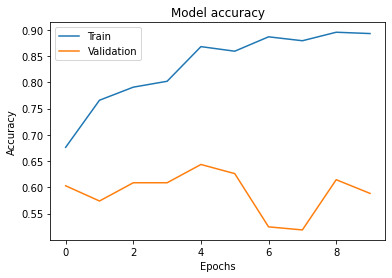

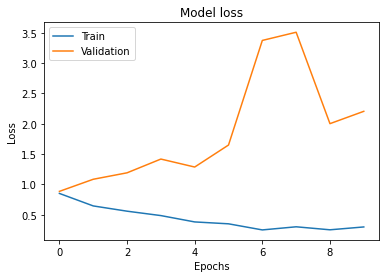

In [43]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

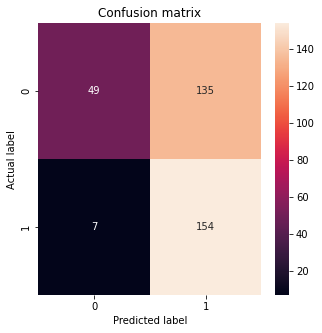

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.88      0.27      0.41       184
           1       0.53      0.96      0.68       161

    accuracy                           0.59       345
   macro avg       0.70      0.61      0.55       345
weighted avg       0.72      0.59      0.54       345



## 새로운 연예인 이미지로 확률이 어떻게 나오는지 확인

In [75]:
def load_and_preprocess_image(img_path):
    # 이미지 불러오기
    img = image.load_img(img_path, target_size=(224, 224))
    # 이미지를 배열로 변환
    img_array = image.img_to_array(img)
    # 이미지 전처리 (스케일링 등)
    img_array = preprocess_input(img_array)
    return img_array

In [79]:
# 새로운 이미지 불러오기 (예: 'new_image.jpg')
new_image = load_and_preprocess_image('서현진.jpg')

# 이미지를 모델의 입력 형태에 맞게 변환
new_image = np.expand_dims(new_image, axis=0)

# 이미지에 대한 예측 수행
predictions = model.predict(new_image)

# 예측 결과 출력
print(predictions)

# 확률을 퍼센트로 변환
predictions_percent = predictions * 100

# 예측 결과 출력
print(predictions_percent)

[[0. 1.]]
[[  0. 100.]]


In [ ]:
# 1-1-2

## 정규화, random_state=42, batch_size=16, epochs=30, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [46]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [47]:
x_train[0]

array([[[0.26666667, 0.24313725, 0.19215686],
        [0.18431373, 0.14901961, 0.10196078],
        [0.24313725, 0.19607843, 0.1372549 ],
        ...,
        [0.76078431, 0.81176471, 0.85098039],
        [0.63529412, 0.75294118, 0.75294118],
        [0.52156863, 0.71372549, 0.67058824]],

       [[0.36078431, 0.34509804, 0.29411765],
        [0.20392157, 0.17647059, 0.12941176],
        [0.23921569, 0.2       , 0.14901961],
        ...,
        [0.75686275, 0.80784314, 0.84313725],
        [0.61960784, 0.75294118, 0.74509804],
        [0.50588235, 0.70196078, 0.65490196]],

       [[0.4627451 , 0.45490196, 0.40784314],
        [0.32156863, 0.30980392, 0.26666667],
        [0.30588235, 0.28235294, 0.23137255],
        ...,
        [0.74901961, 0.80784314, 0.84313725],
        [0.60784314, 0.74901961, 0.74117647],
        [0.50196078, 0.70196078, 0.65098039]],

       ...,

       [[0.14509804, 0.16470588, 0.21176471],
        [0.1254902 , 0.1372549 , 0.18431373],
        [0.1254902 , 0

## 데이터 증강

In [48]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [49]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [50]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [51]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
51/51 [==============================] - 13s 191ms/step - loss: 1.0433 - accuracy: 0.6339 - val_loss: 1.3824 - val_accuracy: 0.5275
Epoch 2/30
51/51 [==============================] - 9s 168ms/step - loss: 0.5227 - accuracy: 0.7908 - val_loss: 0.8979 - val_accuracy: 0.6551
Epoch 3/30
51/51 [==============================] - 9s 168ms/step - loss: 0.4691 - accuracy: 0.8344 - val_loss: 1.1461 - val_accuracy: 0.6116
Epoch 4/30
51/51 [==============================] - 9s 166ms/step - loss: 0.4238 - accuracy: 0.8456 - val_loss: 2.4781 - val_accuracy: 0.4899
Epoch 5/30
51/51 [==============================] - 9s 170ms/step - loss: 0.4277 - accuracy: 0.8605 - val_loss: 2.7303 - val_accuracy: 0.5014
Epoch 6/30
51/51 [==============================] - 8s 165ms/step - loss: 0.3596 - accuracy: 0.8692 - val_loss: 3.1833 - val_accuracy: 0.4986
Epoch 7/30
51/51 [==============================] - 9s 167ms/step - loss: 0.2717 - accuracy: 0.8829 - val_loss: 4.8733 - val_accuracy: 0.4870
Epoch

## (6) 예측하기

In [52]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [53]:
print(pred_class)
print(y_val)
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [54]:
# pred_class가 1로만 나옴

acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.466667


## loss, accuracy 시각화

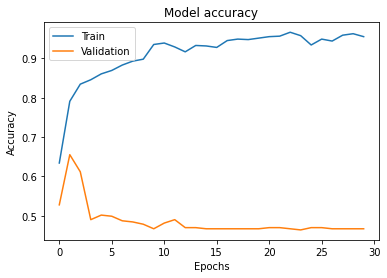

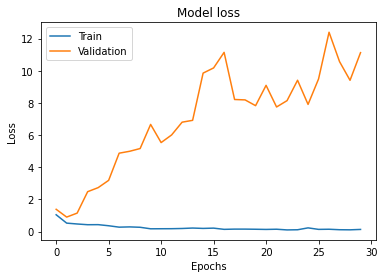

In [56]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

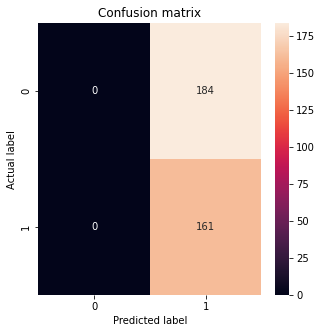

In [57]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       184
           1       0.47      1.00      0.64       161

    accuracy                           0.47       345
   macro avg       0.23      0.50      0.32       345
weighted avg       0.22      0.47      0.30       345



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 1-1-3


## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [59]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


## 데이터 증강

In [60]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [61]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [62]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [63]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
51/51 [==============================] - 13s 190ms/step - loss: 0.8883 - accuracy: 0.6663 - val_loss: 1.0831 - val_accuracy: 0.5391
Epoch 2/50
51/51 [==============================] - 9s 167ms/step - loss: 0.5795 - accuracy: 0.7783 - val_loss: 1.4641 - val_accuracy: 0.5246
Epoch 3/50
51/51 [==============================] - 9s 166ms/step - loss: 0.4874 - accuracy: 0.8157 - val_loss: 2.0799 - val_accuracy: 0.4725
Epoch 4/50
51/51 [==============================] - 9s 168ms/step - loss: 0.5216 - accuracy: 0.8120 - val_loss: 1.2229 - val_accuracy: 0.5855
Epoch 5/50
51/51 [==============================] - 9s 173ms/step - loss: 0.3996 - accuracy: 0.8605 - val_loss: 1.0890 - val_accuracy: 0.6435
Epoch 6/50
51/51 [==============================] - 9s 167ms/step - loss: 0.3649 - accuracy: 0.8705 - val_loss: 1.6297 - val_accuracy: 0.5826
Epoch 7/50
51/51 [==============================] - 8s 164ms/step - loss: 0.3477 - accuracy: 0.8879 - val_loss: 3.7659 - val_accuracy: 0.4783
Epoch

## (6) 예측하기

In [64]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [65]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [66]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.495652


## loss, accuracy 시각화

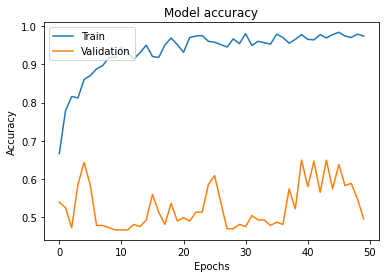

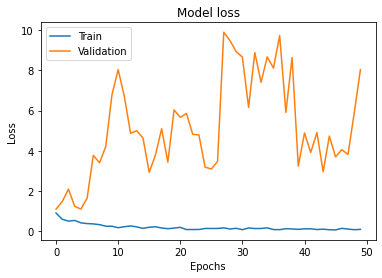

In [67]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

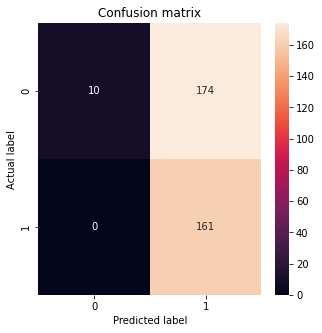

In [68]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       1.00      0.05      0.10       184
           1       0.48      1.00      0.65       161

    accuracy                           0.50       345
   macro avg       0.74      0.53      0.38       345
weighted avg       0.76      0.50      0.36       345



In [ ]:
## 1-2-1

## 정규화, random_state=42, batch_size=16, epochs=10, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [70]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [97]:
x_train[0]

array([[[0.6745098 , 0.64705882, 0.56470588],
        [0.67058824, 0.65098039, 0.56078431],
        [0.69803922, 0.6627451 , 0.58823529],
        ...,
        [0.69411765, 0.66666667, 0.59607843],
        [0.69019608, 0.6627451 , 0.59215686],
        [0.70980392, 0.68235294, 0.61176471]],

       [[0.6627451 , 0.63137255, 0.56862745],
        [0.6745098 , 0.63921569, 0.57254902],
        [0.70980392, 0.65882353, 0.6       ],
        ...,
        [0.68235294, 0.6627451 , 0.59607843],
        [0.68235294, 0.65882353, 0.58823529],
        [0.71764706, 0.68235294, 0.61568627]],

       [[0.65882353, 0.62745098, 0.55294118],
        [0.66666667, 0.63921569, 0.56078431],
        [0.70196078, 0.65882353, 0.58823529],
        ...,
        [0.67843137, 0.67843137, 0.59607843],
        [0.6745098 , 0.66666667, 0.58823529],
        [0.72156863, 0.68627451, 0.61176471]],

       ...,

       [[0.81176471, 0.8627451 , 0.90980392],
        [0.81960784, 0.85882353, 0.91764706],
        [0.81960784, 0

## 데이터 증강

In [72]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [73]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [74]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [75]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
51/51 [==============================] - 13s 189ms/step - loss: 1.1250 - accuracy: 0.4907 - val_loss: 0.8846 - val_accuracy: 0.5507
Epoch 2/10
51/51 [==============================] - 9s 172ms/step - loss: 0.8936 - accuracy: 0.5741 - val_loss: 0.8807 - val_accuracy: 0.5623
Epoch 3/10
51/51 [==============================] - 8s 164ms/step - loss: 0.7664 - accuracy: 0.6488 - val_loss: 0.8542 - val_accuracy: 0.5884
Epoch 4/10
51/51 [==============================] - 8s 164ms/step - loss: 0.7053 - accuracy: 0.6800 - val_loss: 0.8282 - val_accuracy: 0.6116
Epoch 5/10
51/51 [==============================] - 8s 163ms/step - loss: 0.6517 - accuracy: 0.7086 - val_loss: 0.8603 - val_accuracy: 0.5681
Epoch 6/10
51/51 [==============================] - 9s 166ms/step - loss: 0.6076 - accuracy: 0.7460 - val_loss: 0.8146 - val_accuracy: 0.6116
Epoch 7/10
51/51 [==============================] - 9s 165ms/step - loss: 0.6128 - accuracy: 0.7347 - val_loss: 0.7912 - val_accuracy: 0.6406
Epoch

## (6) 예측하기

In [76]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [77]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0
 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1
 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1
 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1
 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0
 1 1 1 0 1 0 0 1 0 0 1 0]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [78]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.634783


## loss, accuracy 시각화

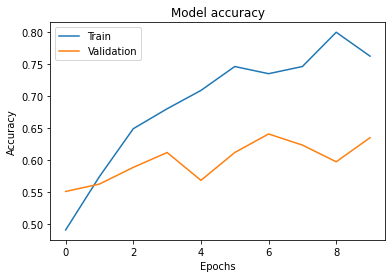

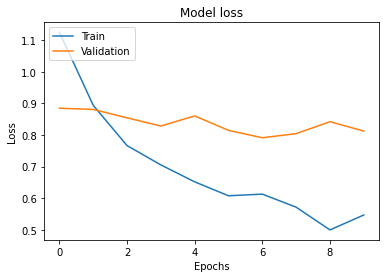

In [79]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

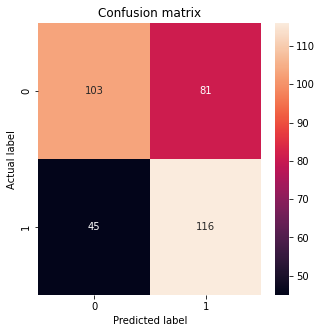

In [80]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [81]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       184
           1       0.59      0.72      0.65       161

    accuracy                           0.63       345
   macro avg       0.64      0.64      0.63       345
weighted avg       0.65      0.63      0.63       345



In [ ]:
# 1-2-2

## 정규화, random_state=42, batch_size=16, epochs=30, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [82]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [109]:
x_train[0]

array([[[0.6745098 , 0.64705882, 0.56470588],
        [0.67058824, 0.65098039, 0.56078431],
        [0.69803922, 0.6627451 , 0.58823529],
        ...,
        [0.69411765, 0.66666667, 0.59607843],
        [0.69019608, 0.6627451 , 0.59215686],
        [0.70980392, 0.68235294, 0.61176471]],

       [[0.6627451 , 0.63137255, 0.56862745],
        [0.6745098 , 0.63921569, 0.57254902],
        [0.70980392, 0.65882353, 0.6       ],
        ...,
        [0.68235294, 0.6627451 , 0.59607843],
        [0.68235294, 0.65882353, 0.58823529],
        [0.71764706, 0.68235294, 0.61568627]],

       [[0.65882353, 0.62745098, 0.55294118],
        [0.66666667, 0.63921569, 0.56078431],
        [0.70196078, 0.65882353, 0.58823529],
        ...,
        [0.67843137, 0.67843137, 0.59607843],
        [0.6745098 , 0.66666667, 0.58823529],
        [0.72156863, 0.68627451, 0.61176471]],

       ...,

       [[0.81176471, 0.8627451 , 0.90980392],
        [0.81960784, 0.85882353, 0.91764706],
        [0.81960784, 0

## 데이터 증강

In [83]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [84]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [85]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [86]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
51/51 [==============================] - 14s 193ms/step - loss: 1.0524 - accuracy: 0.5629 - val_loss: 1.1442 - val_accuracy: 0.5188
Epoch 2/30
51/51 [==============================] - 8s 165ms/step - loss: 0.9159 - accuracy: 0.6127 - val_loss: 1.0294 - val_accuracy: 0.5478
Epoch 3/30
51/51 [==============================] - 8s 167ms/step - loss: 0.7785 - accuracy: 0.6426 - val_loss: 1.0387 - val_accuracy: 0.5623
Epoch 4/30
51/51 [==============================] - 9s 166ms/step - loss: 0.6697 - accuracy: 0.6837 - val_loss: 1.2019 - val_accuracy: 0.5333
Epoch 5/30
51/51 [==============================] - 9s 165ms/step - loss: 0.6258 - accuracy: 0.7161 - val_loss: 1.0890 - val_accuracy: 0.5739
Epoch 6/30
51/51 [==============================] - 9s 166ms/step - loss: 0.6207 - accuracy: 0.7273 - val_loss: 0.9649 - val_accuracy: 0.5855
Epoch 7/30
51/51 [==============================] - 9s 166ms/step - loss: 0.5627 - accuracy: 0.7435 - val_loss: 0.9161 - val_accuracy: 0.6116
Epoch

## (6) 예측하기

In [87]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [88]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0
 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 1 0]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [89]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.663768


## loss, accuracy 시각화

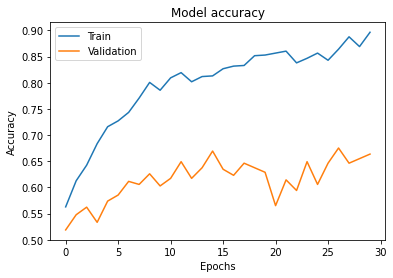

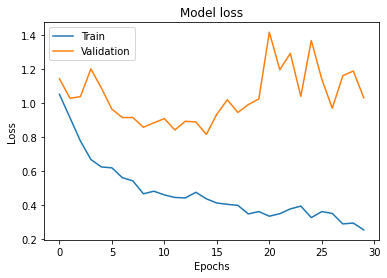

In [90]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

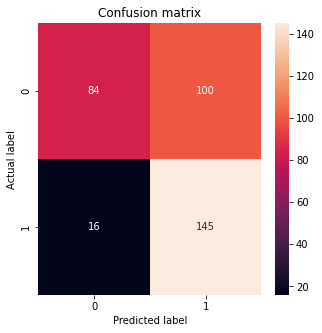

In [91]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [92]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.84      0.46      0.59       184
           1       0.59      0.90      0.71       161

    accuracy                           0.66       345
   macro avg       0.72      0.68      0.65       345
weighted avg       0.72      0.66      0.65       345



In [ ]:
# 1-2-3

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [17]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [18]:
x_train[0]

array([[[0.26666667, 0.24313725, 0.19215686],
        [0.18431373, 0.14901961, 0.10196078],
        [0.24313725, 0.19607843, 0.1372549 ],
        ...,
        [0.76078431, 0.81176471, 0.85098039],
        [0.63529412, 0.75294118, 0.75294118],
        [0.52156863, 0.71372549, 0.67058824]],

       [[0.36078431, 0.34509804, 0.29411765],
        [0.20392157, 0.17647059, 0.12941176],
        [0.23921569, 0.2       , 0.14901961],
        ...,
        [0.75686275, 0.80784314, 0.84313725],
        [0.61960784, 0.75294118, 0.74509804],
        [0.50588235, 0.70196078, 0.65490196]],

       [[0.4627451 , 0.45490196, 0.40784314],
        [0.32156863, 0.30980392, 0.26666667],
        [0.30588235, 0.28235294, 0.23137255],
        ...,
        [0.74901961, 0.80784314, 0.84313725],
        [0.60784314, 0.74901961, 0.74117647],
        [0.50196078, 0.70196078, 0.65098039]],

       ...,

       [[0.14509804, 0.16470588, 0.21176471],
        [0.1254902 , 0.1372549 , 0.18431373],
        [0.1254902 , 0

## 데이터 증강

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [22]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

9420800/9406464 [==============================] - 0s 0us/step


In [23]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [24]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
51/51 [==============================] - 57s 235ms/step - loss: 1.0696 - accuracy: 0.5268 - val_loss: 1.0172 - val_accuracy: 0.4986
Epoch 2/50
51/51 [==============================] - 9s 174ms/step - loss: 0.9006 - accuracy: 0.5878 - val_loss: 0.9763 - val_accuracy: 0.5043
Epoch 3/50
51/51 [==============================] - 9s 173ms/step - loss: 0.7935 - accuracy: 0.6526 - val_loss: 0.9822 - val_accuracy: 0.5014
Epoch 4/50
51/51 [==============================] - 9s 174ms/step - loss: 0.7086 - accuracy: 0.7073 - val_loss: 0.9428 - val_accuracy: 0.5159
Epoch 5/50
51/51 [==============================] - 9s 173ms/step - loss: 0.5844 - accuracy: 0.7534 - val_loss: 0.8987 - val_accuracy: 0.5217
Epoch 6/50
51/51 [==============================] - 9s 170ms/step - loss: 0.5886 - accuracy: 0.7497 - val_loss: 0.8891 - val_accuracy: 0.5478
Epoch 7/50
51/51 [==============================] - 9s 179ms/step - loss: 0.6426 - accuracy: 0.7422 - val_loss: 0.8783 - val_accuracy: 0.5768
Epoch

## (6) 예측하기

In [25]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [26]:
print(pred_class)
print(y_val)
print(pred)

[0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1
 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0
 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0
 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0
 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0
 1 1 1 1 0 1 1 0 1 1 1 1]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [27]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.721739


## loss, accuracy 시각화

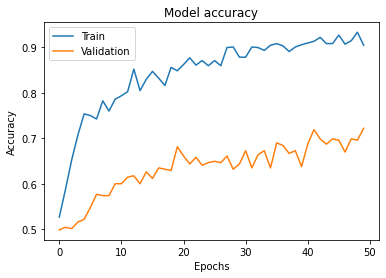

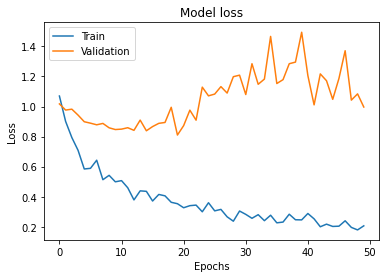

In [28]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

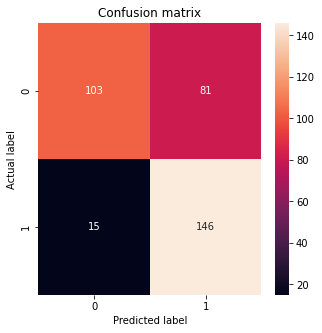

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       184
           1       0.64      0.91      0.75       161

    accuracy                           0.72       345
   macro avg       0.76      0.73      0.72       345
weighted avg       0.77      0.72      0.71       345



In [ ]:
# 1-3-1

## 정규화, random_state=42, batch_size=16, epochs=10, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [40]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [133]:
x_train[0]

array([[[0.6745098 , 0.64705882, 0.56470588],
        [0.67058824, 0.65098039, 0.56078431],
        [0.69803922, 0.6627451 , 0.58823529],
        ...,
        [0.69411765, 0.66666667, 0.59607843],
        [0.69019608, 0.6627451 , 0.59215686],
        [0.70980392, 0.68235294, 0.61176471]],

       [[0.6627451 , 0.63137255, 0.56862745],
        [0.6745098 , 0.63921569, 0.57254902],
        [0.70980392, 0.65882353, 0.6       ],
        ...,
        [0.68235294, 0.6627451 , 0.59607843],
        [0.68235294, 0.65882353, 0.58823529],
        [0.71764706, 0.68235294, 0.61568627]],

       [[0.65882353, 0.62745098, 0.55294118],
        [0.66666667, 0.63921569, 0.56078431],
        [0.70196078, 0.65882353, 0.58823529],
        ...,
        [0.67843137, 0.67843137, 0.59607843],
        [0.6745098 , 0.66666667, 0.58823529],
        [0.72156863, 0.68627451, 0.61176471]],

       ...,

       [[0.81176471, 0.8627451 , 0.90980392],
        [0.81960784, 0.85882353, 0.91764706],
        [0.81960784, 0

## 데이터 증강

In [41]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [42]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [43]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [44]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
51/51 [==============================] - 14s 202ms/step - loss: 1.0637 - accuracy: 0.5118 - val_loss: 1.0010 - val_accuracy: 0.5188
Epoch 2/10
51/51 [==============================] - 9s 175ms/step - loss: 0.9931 - accuracy: 0.5430 - val_loss: 1.0104 - val_accuracy: 0.5362
Epoch 3/10
51/51 [==============================] - 9s 174ms/step - loss: 0.9608 - accuracy: 0.5604 - val_loss: 1.0035 - val_accuracy: 0.5304
Epoch 4/10
51/51 [==============================] - 9s 174ms/step - loss: 0.9955 - accuracy: 0.5467 - val_loss: 0.9968 - val_accuracy: 0.5304
Epoch 5/10
51/51 [==============================] - 9s 171ms/step - loss: 0.9309 - accuracy: 0.5828 - val_loss: 1.0018 - val_accuracy: 0.5362
Epoch 6/10
51/51 [==============================] - 9s 172ms/step - loss: 1.0146 - accuracy: 0.5592 - val_loss: 0.9679 - val_accuracy: 0.5420
Epoch 7/10
51/51 [==============================] - 9s 173ms/step - loss: 0.8962 - accuracy: 0.5828 - val_loss: 0.9459 - val_accuracy: 0.5362
Epoch

## (6) 예측하기

In [45]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [46]:
print(pred_class)
print(y_val)
print(pred)

[0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0
 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1
 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1
 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0
 1 1 1 1 1 1 0 0 1 0 0 0]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [47]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.568116


## loss, accuracy 시각화

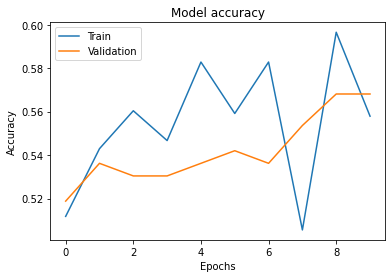

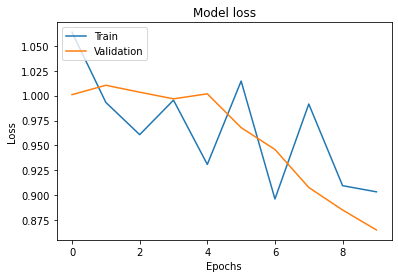

In [48]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

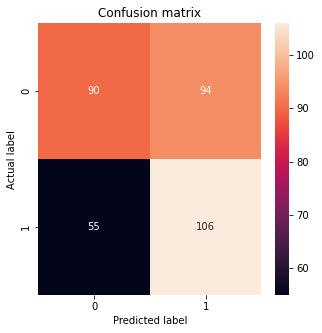

In [49]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [50]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.62      0.49      0.55       184
           1       0.53      0.66      0.59       161

    accuracy                           0.57       345
   macro avg       0.58      0.57      0.57       345
weighted avg       0.58      0.57      0.57       345



In [ ]:
# 1-3-2

## 정규화, random_state=42, batch_size=16, epochs=30, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [51]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [52]:
x_train[0]

array([[[0.26666667, 0.24313725, 0.19215686],
        [0.18431373, 0.14901961, 0.10196078],
        [0.24313725, 0.19607843, 0.1372549 ],
        ...,
        [0.76078431, 0.81176471, 0.85098039],
        [0.63529412, 0.75294118, 0.75294118],
        [0.52156863, 0.71372549, 0.67058824]],

       [[0.36078431, 0.34509804, 0.29411765],
        [0.20392157, 0.17647059, 0.12941176],
        [0.23921569, 0.2       , 0.14901961],
        ...,
        [0.75686275, 0.80784314, 0.84313725],
        [0.61960784, 0.75294118, 0.74509804],
        [0.50588235, 0.70196078, 0.65490196]],

       [[0.4627451 , 0.45490196, 0.40784314],
        [0.32156863, 0.30980392, 0.26666667],
        [0.30588235, 0.28235294, 0.23137255],
        ...,
        [0.74901961, 0.80784314, 0.84313725],
        [0.60784314, 0.74901961, 0.74117647],
        [0.50196078, 0.70196078, 0.65098039]],

       ...,

       [[0.14509804, 0.16470588, 0.21176471],
        [0.1254902 , 0.1372549 , 0.18431373],
        [0.1254902 , 0

## 데이터 증강

In [53]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [54]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [55]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [56]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
51/51 [==============================] - 14s 197ms/step - loss: 1.1292 - accuracy: 0.5342 - val_loss: 1.0540 - val_accuracy: 0.5101
Epoch 2/30
51/51 [==============================] - 9s 171ms/step - loss: 1.0738 - accuracy: 0.5230 - val_loss: 1.0725 - val_accuracy: 0.4870
Epoch 3/30
51/51 [==============================] - 9s 170ms/step - loss: 1.0656 - accuracy: 0.5330 - val_loss: 1.0701 - val_accuracy: 0.4899
Epoch 4/30
51/51 [==============================] - 9s 180ms/step - loss: 1.0956 - accuracy: 0.5056 - val_loss: 1.0759 - val_accuracy: 0.4870
Epoch 5/30
51/51 [==============================] - 9s 169ms/step - loss: 1.0040 - accuracy: 0.5367 - val_loss: 1.0658 - val_accuracy: 0.4986
Epoch 6/30
51/51 [==============================] - 9s 170ms/step - loss: 0.9450 - accuracy: 0.5654 - val_loss: 1.0446 - val_accuracy: 0.5043
Epoch 7/30
51/51 [==============================] - 9s 171ms/step - loss: 0.9739 - accuracy: 0.5716 - val_loss: 1.0511 - val_accuracy: 0.5304
Epoch

## (6) 예측하기

In [57]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [58]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0
 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1
 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0
 0 1 1 1 0 1 1 0 1 0 1 0]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [59]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.588406


## loss, accuracy 시각화

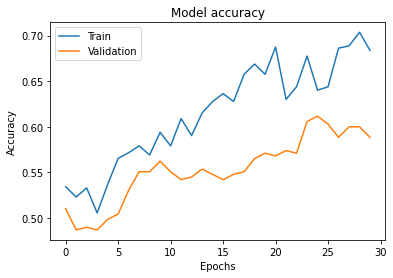

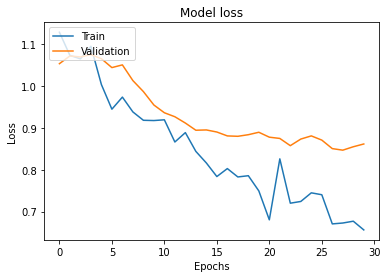

In [60]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

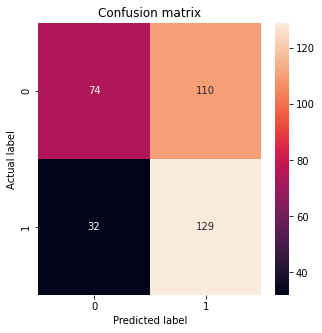

In [61]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [62]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.70      0.40      0.51       184
           1       0.54      0.80      0.64       161

    accuracy                           0.59       345
   macro avg       0.62      0.60      0.58       345
weighted avg       0.62      0.59      0.57       345



In [ ]:
# 1-3-3

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [63]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [157]:
x_train[0]

array([[[0.6745098 , 0.64705882, 0.56470588],
        [0.67058824, 0.65098039, 0.56078431],
        [0.69803922, 0.6627451 , 0.58823529],
        ...,
        [0.69411765, 0.66666667, 0.59607843],
        [0.69019608, 0.6627451 , 0.59215686],
        [0.70980392, 0.68235294, 0.61176471]],

       [[0.6627451 , 0.63137255, 0.56862745],
        [0.6745098 , 0.63921569, 0.57254902],
        [0.70980392, 0.65882353, 0.6       ],
        ...,
        [0.68235294, 0.6627451 , 0.59607843],
        [0.68235294, 0.65882353, 0.58823529],
        [0.71764706, 0.68235294, 0.61568627]],

       [[0.65882353, 0.62745098, 0.55294118],
        [0.66666667, 0.63921569, 0.56078431],
        [0.70196078, 0.65882353, 0.58823529],
        ...,
        [0.67843137, 0.67843137, 0.59607843],
        [0.6745098 , 0.66666667, 0.58823529],
        [0.72156863, 0.68627451, 0.61176471]],

       ...,

       [[0.81176471, 0.8627451 , 0.90980392],
        [0.81960784, 0.85882353, 0.91764706],
        [0.81960784, 0

## 데이터 증강

In [64]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=16)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [65]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [66]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [67]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
51/51 [==============================] - 14s 200ms/step - loss: 1.2174 - accuracy: 0.4795 - val_loss: 1.1356 - val_accuracy: 0.5217
Epoch 2/50
51/51 [==============================] - 9s 188ms/step - loss: 1.2129 - accuracy: 0.4932 - val_loss: 1.1137 - val_accuracy: 0.5188
Epoch 3/50
51/51 [==============================] - 9s 171ms/step - loss: 1.1287 - accuracy: 0.4919 - val_loss: 1.1225 - val_accuracy: 0.5159
Epoch 4/50
51/51 [==============================] - 9s 172ms/step - loss: 1.1254 - accuracy: 0.5106 - val_loss: 1.1054 - val_accuracy: 0.5101
Epoch 5/50
51/51 [==============================] - 9s 171ms/step - loss: 1.1247 - accuracy: 0.4981 - val_loss: 1.0923 - val_accuracy: 0.5188
Epoch 6/50
51/51 [==============================] - 9s 174ms/step - loss: 1.0612 - accuracy: 0.5280 - val_loss: 1.0961 - val_accuracy: 0.5217
Epoch 7/50
51/51 [==============================] - 9s 172ms/step - loss: 1.0299 - accuracy: 0.5205 - val_loss: 1.0993 - val_accuracy: 0.5217
Epoch

## (6) 예측하기

In [68]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [69]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1
 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1
 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1
 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0
 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0
 1 1 1 1 0 1 1 0 1 0 1 1]
[0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0

In [70]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.669565


## loss, accuracy 시각화

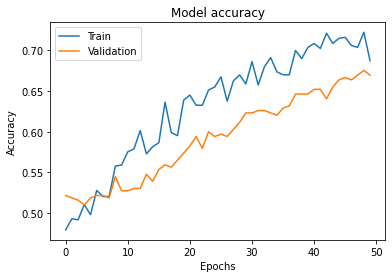

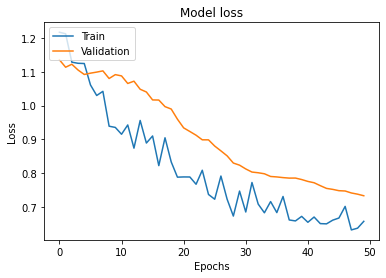

In [71]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

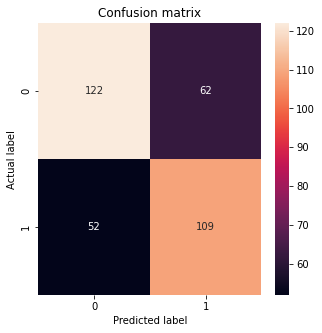

In [72]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [73]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       184
           1       0.64      0.68      0.66       161

    accuracy                           0.67       345
   macro avg       0.67      0.67      0.67       345
weighted avg       0.67      0.67      0.67       345



In [ ]:
# 2-1-1

## 정규화, random_state=42, batch_size=32, epochs=10, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [74]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (803, 224, 224, 3)
y_train:  (803,)
x_val:  (345, 224, 224, 3)
y_val:  (345,)


In [169]:
x_train[0]

array([[[0.6745098 , 0.64705882, 0.56470588],
        [0.67058824, 0.65098039, 0.56078431],
        [0.69803922, 0.6627451 , 0.58823529],
        ...,
        [0.69411765, 0.66666667, 0.59607843],
        [0.69019608, 0.6627451 , 0.59215686],
        [0.70980392, 0.68235294, 0.61176471]],

       [[0.6627451 , 0.63137255, 0.56862745],
        [0.6745098 , 0.63921569, 0.57254902],
        [0.70980392, 0.65882353, 0.6       ],
        ...,
        [0.68235294, 0.6627451 , 0.59607843],
        [0.68235294, 0.65882353, 0.58823529],
        [0.71764706, 0.68235294, 0.61568627]],

       [[0.65882353, 0.62745098, 0.55294118],
        [0.66666667, 0.63921569, 0.56078431],
        [0.70196078, 0.65882353, 0.58823529],
        ...,
        [0.67843137, 0.67843137, 0.59607843],
        [0.6745098 , 0.66666667, 0.58823529],
        [0.72156863, 0.68627451, 0.61176471]],

       ...,

       [[0.81176471, 0.8627451 , 0.90980392],
        [0.81960784, 0.85882353, 0.91764706],
        [0.81960784, 0

## 데이터 증강

In [75]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [76]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [77]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [78]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
26/26 [==============================] - 15s 390ms/step - loss: 0.9809 - accuracy: 0.6526 - val_loss: 1.0009 - val_accuracy: 0.5594
Epoch 2/10
26/26 [==============================] - 9s 337ms/step - loss: 0.6517 - accuracy: 0.7671 - val_loss: 1.0713 - val_accuracy: 0.6058
Epoch 3/10
26/26 [==============================] - 9s 334ms/step - loss: 0.5133 - accuracy: 0.7995 - val_loss: 1.1769 - val_accuracy: 0.6174
Epoch 4/10
26/26 [==============================] - 9s 336ms/step - loss: 0.4887 - accuracy: 0.8232 - val_loss: 1.1101 - val_accuracy: 0.5913
Epoch 5/10
26/26 [==============================] - 9s 331ms/step - loss: 0.4248 - accuracy: 0.8356 - val_loss: 1.3784 - val_accuracy: 0.5536
Epoch 6/10
26/26 [==============================] - 9s 346ms/step - loss: 0.2691 - accuracy: 0.8842 - val_loss: 1.4288 - val_accuracy: 0.5594
Epoch 7/10
26/26 [==============================] - 9s 334ms/step - loss: 0.2750 - accuracy: 0.8966 - val_loss: 1.1657 - val_accuracy: 0.5826
Epoch

## (6) 예측하기

In [174]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [175]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[7.07513690e-02 9.29248631e-01]
 [9.80302036e-01 1.96979847e-02]
 [7.36851096e-02 9.26314950e-01]
 [8.09390008e-01 1.90609992e-01]
 [6.70934841e-02 9.32906568e-01]
 [1.47340909e-01 8.52659047e-01]
 [5.46408235e-04 9.99453604e-01]
 [1.82294533e-01 8.17705452e-01]
 [1.75747126e-01 8.24252903e-01]
 [9.07774031e-01 9.22259763e-02]
 [2.03265801e-01 7.96734214e-01]
 [1.93402953e-02 9.80659664e-01]
 [1.34510756e-03 9.986

In [176]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.594406


## loss, accuracy 시각화

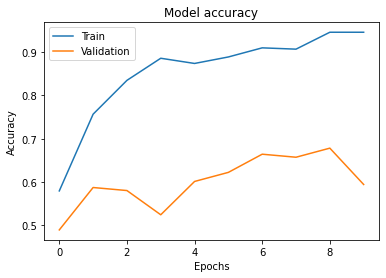

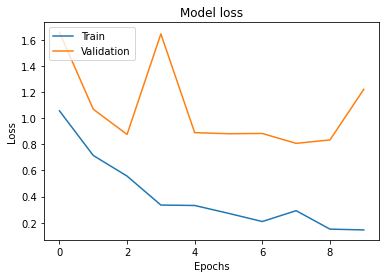

In [177]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

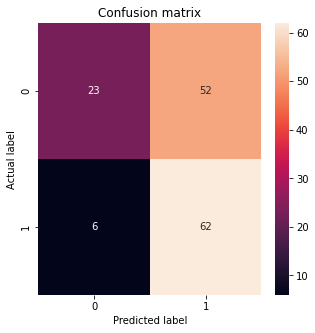

In [178]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [179]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.79      0.31      0.44        75
           1       0.54      0.91      0.68        68

    accuracy                           0.59       143
   macro avg       0.67      0.61      0.56       143
weighted avg       0.67      0.59      0.56       143



In [ ]:
# 2-1-2

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.0001(네번째자리)

## 데이터 바로 사용해도 되는지 확인

In [180]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [181]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [182]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [183]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [184]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
11/11 [==============================] - 8s 454ms/step - loss: 0.8827 - accuracy: 0.6216 - val_loss: 0.9430 - val_accuracy: 0.5944
Epoch 2/30
11/11 [==============================] - 4s 303ms/step - loss: 0.4850 - accuracy: 0.8198 - val_loss: 0.6756 - val_accuracy: 0.6853
Epoch 3/30
11/11 [==============================] - 4s 321ms/step - loss: 0.3692 - accuracy: 0.8709 - val_loss: 0.7077 - val_accuracy: 0.6503
Epoch 4/30
11/11 [==============================] - 4s 312ms/step - loss: 0.3075 - accuracy: 0.8949 - val_loss: 0.8408 - val_accuracy: 0.6154
Epoch 5/30
11/11 [==============================] - 4s 322ms/step - loss: 0.2881 - accuracy: 0.9039 - val_loss: 1.3148 - val_accuracy: 0.5804
Epoch 6/30
11/11 [==============================] - 4s 330ms/step - loss: 0.1928 - accuracy: 0.9279 - val_loss: 0.7720 - val_accuracy: 0.6364
Epoch 7/30
11/11 [==============================] - 4s 322ms/step - loss: 0.2593 - accuracy: 0.9009 - val_loss: 0.8989 - val_accuracy: 0.6154
Epoch 

## (6) 예측하기

In [185]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [186]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[9.96894598e-01 3.10540618e-03]
 [9.99998808e-01 1.24717860e-06]
 [9.99928594e-01 7.14188063e-05]
 [9.99999881e-01 1.40998409e-07]
 [8.58529389e-01 1.41470626e-01]
 [9.99999762e-01 2.08072748e-07]
 [7.00334609e-01 2.99665391e-01]
 [9.99492407e-01 5.07530349e-04]
 [9.96690750e-01 3.30928201e-03]
 [9.99982357e-01 1.76251015e-05]
 [9.12164629e-01 8.78353640e-02]
 [9.66864109e-01 3.31358351e-02]
 [3.88026506e-01 6.119

In [187]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.643357


## loss, accuracy 시각화

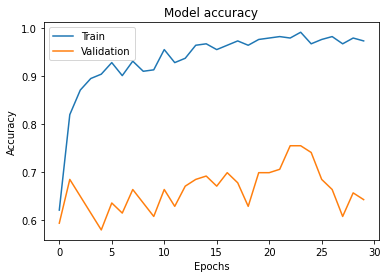

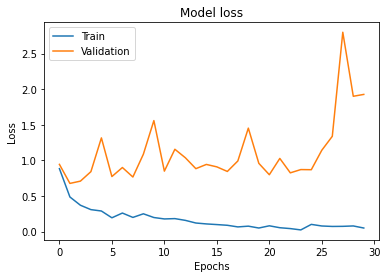

In [188]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

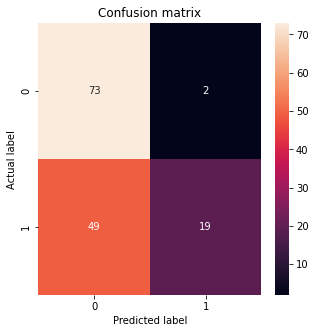

In [189]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [190]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.60      0.97      0.74        75
           1       0.90      0.28      0.43        68

    accuracy                           0.64       143
   macro avg       0.75      0.63      0.58       143
weighted avg       0.74      0.64      0.59       143



In [ ]:
# 2-1-3

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.0001(네번째자리)

## 데이터 바로 사용해도 되는지 확인

In [191]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [192]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [193]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [194]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [195]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
11/11 [==============================] - 8s 407ms/step - loss: 0.9593 - accuracy: 0.6066 - val_loss: 1.2288 - val_accuracy: 0.5594
Epoch 2/50
11/11 [==============================] - 4s 318ms/step - loss: 0.5736 - accuracy: 0.7868 - val_loss: 1.1317 - val_accuracy: 0.5664
Epoch 3/50
11/11 [==============================] - 4s 330ms/step - loss: 0.4226 - accuracy: 0.8348 - val_loss: 0.9391 - val_accuracy: 0.6084
Epoch 4/50
11/11 [==============================] - 4s 301ms/step - loss: 0.3773 - accuracy: 0.8679 - val_loss: 0.9172 - val_accuracy: 0.6434
Epoch 5/50
11/11 [==============================] - 4s 323ms/step - loss: 0.3573 - accuracy: 0.8769 - val_loss: 2.0824 - val_accuracy: 0.5804
Epoch 6/50
11/11 [==============================] - 4s 314ms/step - loss: 0.3294 - accuracy: 0.8979 - val_loss: 1.3072 - val_accuracy: 0.5874
Epoch 7/50
11/11 [==============================] - 4s 308ms/step - loss: 0.2484 - accuracy: 0.9069 - val_loss: 1.1961 - val_accuracy: 0.6084
Epoch 

## (6) 예측하기

In [196]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [197]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1
 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[8.64429474e-01 1.35570467e-01]
 [9.99999762e-01 2.78095598e-07]
 [9.99979496e-01 2.05249689e-05]
 [1.00000000e+00 5.88515725e-09]
 [9.99906778e-01 9.31792456e-05]
 [9.97969329e-01 2.03064037e-03]
 [9.02483735e-05 9.99909759e-01]
 [9.90384459e-01 9.61553026e-03]
 [9.99995947e-01 4.01363241e-06]
 [9.99999881e-01 8.43116368e-08]
 [4.58619297e-01 5.41380703e-01]
 [1.24556967e-03 9.98754382e-01]
 [3.01679890e-08 1.000

In [198]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.783217


## loss, accuracy 시각화

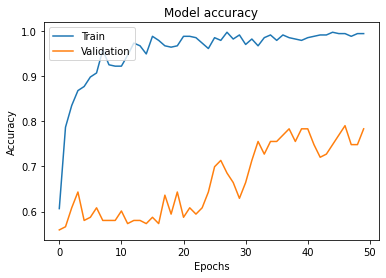

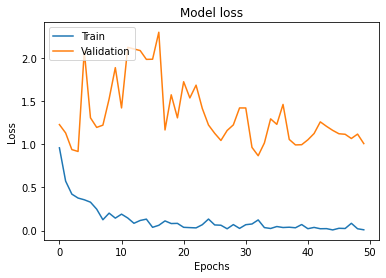

In [199]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

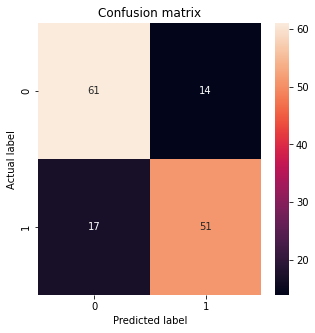

In [200]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [201]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        75
           1       0.78      0.75      0.77        68

    accuracy                           0.78       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.78      0.78      0.78       143



In [ ]:
# 2-2-1

## 정규화, random_state=42, batch_size=32, epochs=10, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [202]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [203]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [204]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [205]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [206]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
11/11 [==============================] - 8s 405ms/step - loss: 1.2293 - accuracy: 0.4985 - val_loss: 1.2676 - val_accuracy: 0.3846
Epoch 2/10
11/11 [==============================] - 4s 332ms/step - loss: 1.0262 - accuracy: 0.5435 - val_loss: 1.2335 - val_accuracy: 0.4336
Epoch 3/10
11/11 [==============================] - 4s 349ms/step - loss: 0.8209 - accuracy: 0.6066 - val_loss: 1.1459 - val_accuracy: 0.4196
Epoch 4/10
11/11 [==============================] - 4s 321ms/step - loss: 0.7725 - accuracy: 0.6486 - val_loss: 1.1205 - val_accuracy: 0.4336
Epoch 5/10
11/11 [==============================] - 4s 330ms/step - loss: 0.6485 - accuracy: 0.6907 - val_loss: 1.1702 - val_accuracy: 0.4545
Epoch 6/10
11/11 [==============================] - 4s 320ms/step - loss: 0.6472 - accuracy: 0.6997 - val_loss: 1.1334 - val_accuracy: 0.4685
Epoch 7/10
11/11 [==============================] - 4s 323ms/step - loss: 0.5821 - accuracy: 0.7237 - val_loss: 1.0648 - val_accuracy: 0.4196
Epoch 

## (6) 예측하기

In [207]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [208]:
print(pred_class)
print(y_val)
print(pred)

[0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.8421466  0.15785344]
 [0.9502412  0.0497588 ]
 [0.2242591  0.7757409 ]
 [0.49963045 0.50036955]
 [0.1506783  0.8493217 ]
 [0.6588748  0.34112522]
 [0.33524683 0.6647532 ]
 [0.9464359  0.05356411]
 [0.29389906 0.7061009 ]
 [0.73419553 0.26580453]
 [0.07816952 0.92183053]
 [0.14572895 0.85427105]
 [0.1450021  0.85499793]
 [0.90382415 0.09617584]
 [0.26020023 0.73979974]
 [0.55003166 0.44996834]
 [0.31901646 0.680

In [209]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.454545


## loss, accuracy 시각화

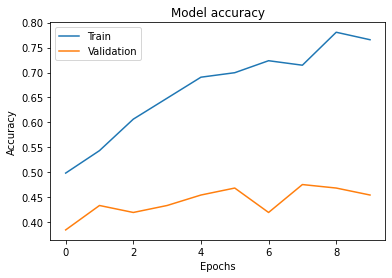

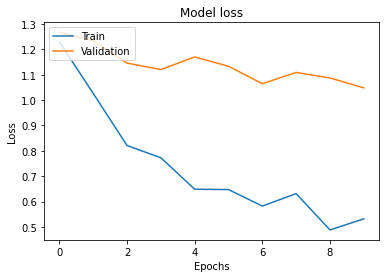

In [210]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

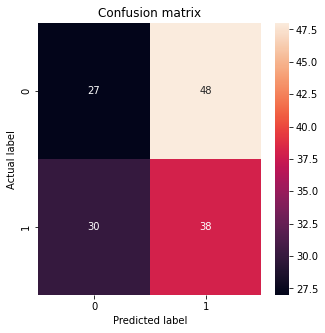

In [211]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [212]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.47      0.36      0.41        75
           1       0.44      0.56      0.49        68

    accuracy                           0.45       143
   macro avg       0.46      0.46      0.45       143
weighted avg       0.46      0.45      0.45       143



In [ ]:
# 2-2-2

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [213]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [214]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [215]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [216]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [217]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
11/11 [==============================] - 9s 412ms/step - loss: 0.9927 - accuracy: 0.5526 - val_loss: 0.9034 - val_accuracy: 0.5175
Epoch 2/30
11/11 [==============================] - 4s 319ms/step - loss: 0.9524 - accuracy: 0.5856 - val_loss: 0.9288 - val_accuracy: 0.5734
Epoch 3/30
11/11 [==============================] - 4s 337ms/step - loss: 0.8400 - accuracy: 0.6186 - val_loss: 0.8366 - val_accuracy: 0.5594
Epoch 4/30
11/11 [==============================] - 4s 319ms/step - loss: 0.6584 - accuracy: 0.6997 - val_loss: 0.8243 - val_accuracy: 0.5734
Epoch 5/30
11/11 [==============================] - 4s 309ms/step - loss: 0.6740 - accuracy: 0.7147 - val_loss: 0.8457 - val_accuracy: 0.6014
Epoch 6/30
11/11 [==============================] - 4s 317ms/step - loss: 0.6320 - accuracy: 0.7147 - val_loss: 0.8094 - val_accuracy: 0.6014
Epoch 7/30
11/11 [==============================] - 4s 329ms/step - loss: 0.5961 - accuracy: 0.7417 - val_loss: 0.7848 - val_accuracy: 0.5804
Epoch 

## (6) 예측하기

In [218]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [219]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[8.53133380e-01 1.46866575e-01]
 [9.74665523e-01 2.53344290e-02]
 [9.93413508e-01 6.58649160e-03]
 [9.86211121e-01 1.37889311e-02]
 [3.61745447e-01 6.38254583e-01]
 [8.90408814e-01 1.09591208e-01]
 [6.70048445e-02 9.32995141e-01]
 [8.14371109e-01 1.85628891e-01]
 [4.65776712e-01 5.34223258e-01]
 [9.80295122e-01 1.97048262e-02]
 [9.44911420e-01 5.50885648e-02]
 [6.13457859e-01 3.86542141e-01]
 [1.41355723e-01 8.586

In [220]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.622378


## loss, accuracy 시각화

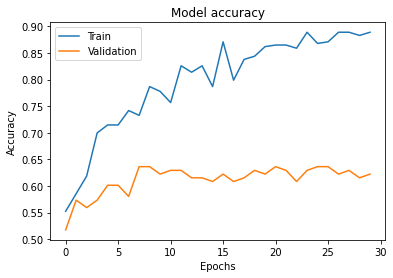

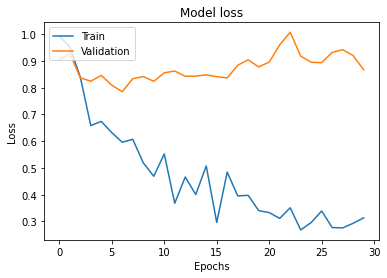

In [221]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

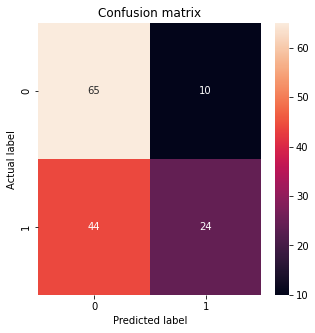

In [222]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [223]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71        75
           1       0.71      0.35      0.47        68

    accuracy                           0.62       143
   macro avg       0.65      0.61      0.59       143
weighted avg       0.65      0.62      0.59       143



In [ ]:
# 2-2-3

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [224]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [225]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [226]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [227]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [228]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
11/11 [==============================] - 9s 420ms/step - loss: 1.2096 - accuracy: 0.4925 - val_loss: 1.1415 - val_accuracy: 0.4685
Epoch 2/50
11/11 [==============================] - 4s 313ms/step - loss: 0.9942 - accuracy: 0.5165 - val_loss: 1.0488 - val_accuracy: 0.4755
Epoch 3/50
11/11 [==============================] - 4s 323ms/step - loss: 0.8819 - accuracy: 0.6006 - val_loss: 0.9945 - val_accuracy: 0.4895
Epoch 4/50
11/11 [==============================] - 4s 348ms/step - loss: 0.7665 - accuracy: 0.6727 - val_loss: 0.9804 - val_accuracy: 0.4895
Epoch 5/50
11/11 [==============================] - 4s 311ms/step - loss: 0.6784 - accuracy: 0.6607 - val_loss: 0.9582 - val_accuracy: 0.5175
Epoch 6/50
11/11 [==============================] - 4s 330ms/step - loss: 0.7003 - accuracy: 0.7177 - val_loss: 0.9433 - val_accuracy: 0.5315
Epoch 7/50
11/11 [==============================] - 4s 318ms/step - loss: 0.5563 - accuracy: 0.7417 - val_loss: 0.9377 - val_accuracy: 0.5455
Epoch 

## (6) 예측하기

In [229]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [230]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.35837737 0.64162266]
 [0.987399   0.01260096]
 [0.4989654  0.50103456]
 [0.9597232  0.04027689]
 [0.9273858  0.07261422]
 [0.97883976 0.02116019]
 [0.03013219 0.9698678 ]
 [0.5759043  0.4240957 ]
 [0.92027545 0.07972459]
 [0.97836405 0.02163592]
 [0.17743237 0.82256764]
 [0.05426966 0.9457303 ]
 [0.00910812 0.9908919 ]
 [0.09644219 0.9035578 ]
 [0.9033131  0.09668688]
 [0.21322393 0.78677607]
 [0.52630025 0.473

In [231]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.664336


## loss, accuracy 시각화

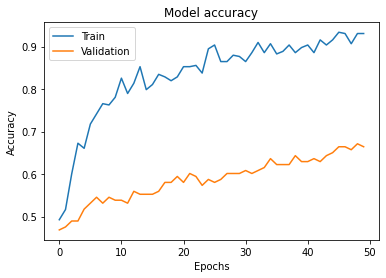

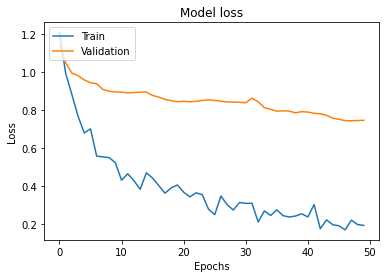

In [232]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

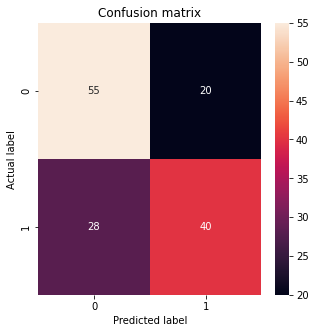

In [233]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [234]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70        75
           1       0.67      0.59      0.62        68

    accuracy                           0.66       143
   macro avg       0.66      0.66      0.66       143
weighted avg       0.66      0.66      0.66       143



In [ ]:
# 2-3-1

## 정규화, random_state=42, batch_size=32, epochs=10, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [235]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [236]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [237]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [238]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [239]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
11/11 [==============================] - 9s 496ms/step - loss: 1.1347 - accuracy: 0.4895 - val_loss: 0.9978 - val_accuracy: 0.5245
Epoch 2/10
11/11 [==============================] - 4s 324ms/step - loss: 1.1775 - accuracy: 0.4775 - val_loss: 0.9964 - val_accuracy: 0.5315
Epoch 3/10
11/11 [==============================] - 4s 308ms/step - loss: 1.0902 - accuracy: 0.5495 - val_loss: 0.9938 - val_accuracy: 0.5315
Epoch 4/10
11/11 [==============================] - 4s 319ms/step - loss: 1.0239 - accuracy: 0.5676 - val_loss: 0.9959 - val_accuracy: 0.5315
Epoch 5/10
11/11 [==============================] - 4s 324ms/step - loss: 1.0877 - accuracy: 0.5135 - val_loss: 0.9945 - val_accuracy: 0.5315
Epoch 6/10
11/11 [==============================] - 4s 354ms/step - loss: 0.9837 - accuracy: 0.5526 - val_loss: 0.9952 - val_accuracy: 0.5245
Epoch 7/10
11/11 [==============================] - 4s 315ms/step - loss: 1.1109 - accuracy: 0.5045 - val_loss: 0.9966 - val_accuracy: 0.5245
Epoch 

## (6) 예측하기

In [240]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [241]:
print(pred_class)
print(y_val)
print(pred)

[0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1
 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.77614605 0.22385398]
 [0.10877412 0.8912258 ]
 [0.2306684  0.76933163]
 [0.4813211  0.5186789 ]
 [0.83844554 0.16155449]
 [0.4520638  0.5479362 ]
 [0.92742515 0.07257485]
 [0.5783522  0.4216478 ]
 [0.85167795 0.14832208]
 [0.84091955 0.15908042]
 [0.1719561  0.8280439 ]
 [0.35273802 0.6472619 ]
 [0.03631647 0.96368355]
 [0.7211127  0.27888724]
 [0.99894494 0.00105507]
 [0.39752886 0.6024711 ]
 [0.02271148 0.977

In [242]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.517483


## loss, accuracy 시각화

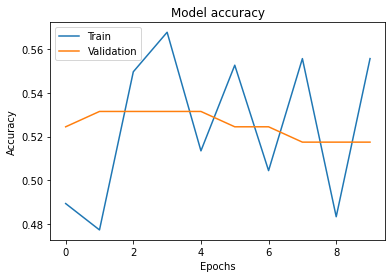

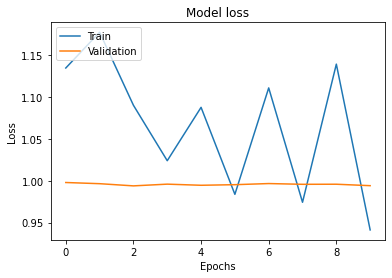

In [243]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

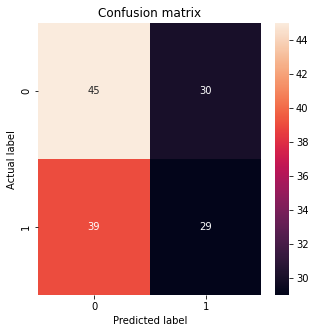

In [244]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [245]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        75
           1       0.49      0.43      0.46        68

    accuracy                           0.52       143
   macro avg       0.51      0.51      0.51       143
weighted avg       0.51      0.52      0.51       143



In [ ]:
# 2-3-2

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [246]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [247]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [248]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [249]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [250]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
11/11 [==============================] - 8s 405ms/step - loss: 1.4290 - accuracy: 0.4715 - val_loss: 1.2002 - val_accuracy: 0.4895
Epoch 2/30
11/11 [==============================] - 4s 344ms/step - loss: 1.1168 - accuracy: 0.5195 - val_loss: 1.2026 - val_accuracy: 0.4895
Epoch 3/30
11/11 [==============================] - 4s 335ms/step - loss: 1.1761 - accuracy: 0.4925 - val_loss: 1.2061 - val_accuracy: 0.5035
Epoch 4/30
11/11 [==============================] - 4s 318ms/step - loss: 1.0075 - accuracy: 0.5526 - val_loss: 1.2125 - val_accuracy: 0.5175
Epoch 5/30
11/11 [==============================] - 4s 304ms/step - loss: 1.1347 - accuracy: 0.5165 - val_loss: 1.2195 - val_accuracy: 0.5175
Epoch 6/30
11/11 [==============================] - 4s 328ms/step - loss: 1.0061 - accuracy: 0.5345 - val_loss: 1.2191 - val_accuracy: 0.5175
Epoch 7/30
11/11 [==============================] - 4s 338ms/step - loss: 1.0273 - accuracy: 0.5315 - val_loss: 1.2163 - val_accuracy: 0.5175
Epoch 

## (6) 예측하기

In [251]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [252]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.95251054 0.04748949]
 [0.97136724 0.02863278]
 [0.9741771  0.02582292]
 [0.97775877 0.02224119]
 [0.10899068 0.89100933]
 [0.6442186  0.35578135]
 [0.9785333  0.02146667]
 [0.6030545  0.39694542]
 [0.9303553  0.06964472]
 [0.9224343  0.07756569]
 [0.29383487 0.70616513]
 [0.33962023 0.66037977]
 [0.77223235 0.22776765]
 [0.66680574 0.33319426]
 [0.5120451  0.4879549 ]
 [0.7436568  0.25634322]
 [0.54182124 0.458

In [253]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.538462


## loss, accuracy 시각화

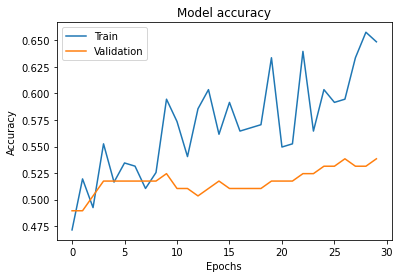

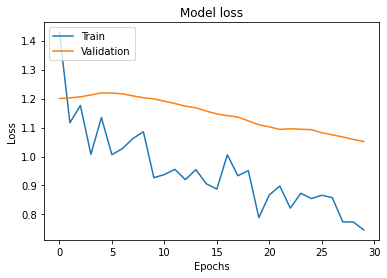

In [254]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

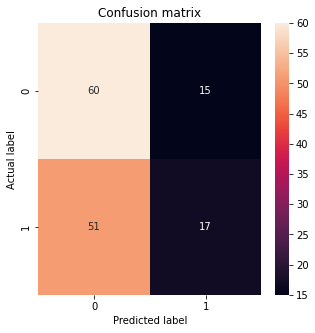

In [255]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [256]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.54      0.80      0.65        75
           1       0.53      0.25      0.34        68

    accuracy                           0.54       143
   macro avg       0.54      0.53      0.49       143
weighted avg       0.54      0.54      0.50       143



In [ ]:
# 2-3-3

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [257]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [258]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=32)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [259]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [260]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [261]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
11/11 [==============================] - 8s 394ms/step - loss: 1.0902 - accuracy: 0.5495 - val_loss: 1.5085 - val_accuracy: 0.4825
Epoch 2/50
11/11 [==============================] - 4s 327ms/step - loss: 1.0379 - accuracy: 0.5165 - val_loss: 1.4852 - val_accuracy: 0.4755
Epoch 3/50
11/11 [==============================] - 4s 347ms/step - loss: 1.0832 - accuracy: 0.5225 - val_loss: 1.4609 - val_accuracy: 0.4895
Epoch 4/50
11/11 [==============================] - 4s 316ms/step - loss: 1.0666 - accuracy: 0.5285 - val_loss: 1.4387 - val_accuracy: 0.4755
Epoch 5/50
11/11 [==============================] - 4s 321ms/step - loss: 0.9468 - accuracy: 0.5676 - val_loss: 1.4365 - val_accuracy: 0.4755
Epoch 6/50
11/11 [==============================] - 4s 328ms/step - loss: 0.9292 - accuracy: 0.5856 - val_loss: 1.4289 - val_accuracy: 0.4615
Epoch 7/50
11/11 [==============================] - 4s 348ms/step - loss: 1.0338 - accuracy: 0.5526 - val_loss: 1.4217 - val_accuracy: 0.4615
Epoch 

## (6) 예측하기

In [262]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [263]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.9689163  0.03108368]
 [0.70845956 0.29154047]
 [0.87943006 0.12056992]
 [0.9666698  0.03333012]
 [0.7664766  0.23352341]
 [0.9286157  0.07138431]
 [0.34748846 0.6525116 ]
 [0.12142257 0.8785774 ]
 [0.690862   0.309138  ]
 [0.58698535 0.41301462]
 [0.23533535 0.76466465]
 [0.717913   0.28208697]
 [0.89800686 0.10199311]
 [0.95678264 0.04321737]
 [0.11471122 0.8852888 ]
 [0.263727   0.736273  ]
 [0.10664903 0.893

In [264]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.503497


## loss, accuracy 시각화

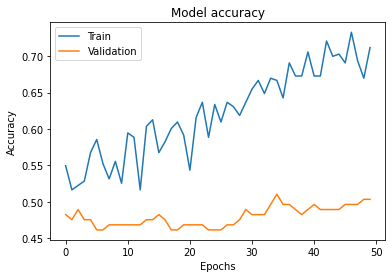

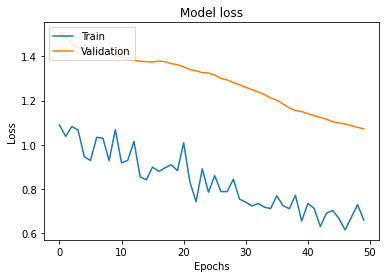

In [265]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

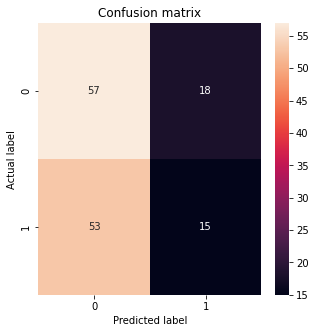

In [266]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [267]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.52      0.76      0.62        75
           1       0.45      0.22      0.30        68

    accuracy                           0.50       143
   macro avg       0.49      0.49      0.46       143
weighted avg       0.49      0.50      0.46       143



In [ ]:
# 3-1-1

## 정규화, random_state=42, batch_size=64, epochs=10, learning rate=0.0001(네번째자리)

## 데이터 바로 사용해도 되는지 확인

In [268]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [269]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [270]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [271]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [272]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 10s 1s/step - loss: 1.1623 - accuracy: 0.5015 - val_loss: 1.2101 - val_accuracy: 0.4965
Epoch 2/10
6/6 [==============================] - 4s 636ms/step - loss: 0.6096 - accuracy: 0.7688 - val_loss: 0.9932 - val_accuracy: 0.5315
Epoch 3/10
6/6 [==============================] - 4s 644ms/step - loss: 0.4409 - accuracy: 0.8258 - val_loss: 1.3129 - val_accuracy: 0.5874
Epoch 4/10
6/6 [==============================] - 4s 769ms/step - loss: 0.4649 - accuracy: 0.8258 - val_loss: 0.9943 - val_accuracy: 0.6084
Epoch 5/10
6/6 [==============================] - 4s 749ms/step - loss: 0.3711 - accuracy: 0.8559 - val_loss: 0.9133 - val_accuracy: 0.6503
Epoch 6/10
6/6 [==============================] - 4s 628ms/step - loss: 0.2657 - accuracy: 0.8859 - val_loss: 0.9854 - val_accuracy: 0.6713
Epoch 7/10
6/6 [==============================] - 4s 594ms/step - loss: 0.2743 - accuracy: 0.8769 - val_loss: 0.8011 - val_accuracy: 0.6294
Epoch 8/10
6/6 [======

## (6) 예측하기

In [273]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [274]:
print(pred_class)
print(y_val)
print(pred)

[1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0
 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[2.8032869e-01 7.1967131e-01]
 [9.6381468e-01 3.6185324e-02]
 [9.3386173e-01 6.6138245e-02]
 [9.6370447e-01 3.6295556e-02]
 [6.3909209e-01 3.6090788e-01]
 [9.7984147e-01 2.0158486e-02]
 [4.7073320e-02 9.5292670e-01]
 [9.2532808e-01 7.4671939e-02]
 [6.4600843e-01 3.5399163e-01]
 [2.6282758e-01 7.3717242e-01]
 [8.5307688e-01 1.4692314e-01]
 [9.2604506e-01 7.3954910e-02]
 [2.6918402e-02 9.7308165e-01]
 [5.1312774e-01

In [275]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.615385


## loss, accuracy 시각화

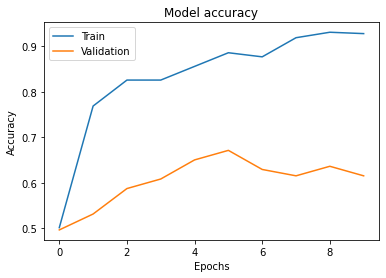

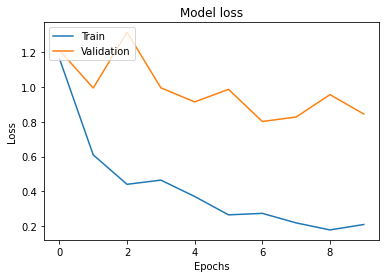

In [276]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

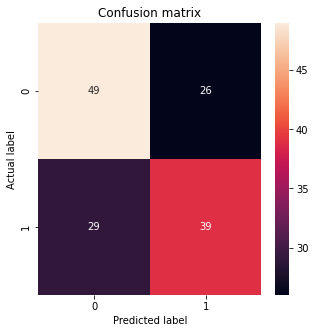

In [277]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [278]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64        75
           1       0.60      0.57      0.59        68

    accuracy                           0.62       143
   macro avg       0.61      0.61      0.61       143
weighted avg       0.61      0.62      0.61       143



In [ ]:
# 3-1-2

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.0001(네번째자리)

## 데이터 바로 사용해도 되는지 확인

In [279]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [280]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [281]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [282]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [283]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
6/6 [==============================] - 9s 837ms/step - loss: 0.9354 - accuracy: 0.6426 - val_loss: 0.7950 - val_accuracy: 0.5874
Epoch 2/30
6/6 [==============================] - 4s 635ms/step - loss: 0.5811 - accuracy: 0.7748 - val_loss: 0.7243 - val_accuracy: 0.6573
Epoch 3/30
6/6 [==============================] - 4s 621ms/step - loss: 0.4521 - accuracy: 0.8168 - val_loss: 0.6471 - val_accuracy: 0.6643
Epoch 4/30
6/6 [==============================] - 4s 737ms/step - loss: 0.4212 - accuracy: 0.8529 - val_loss: 0.7223 - val_accuracy: 0.7063
Epoch 5/30
6/6 [==============================] - 4s 564ms/step - loss: 0.2359 - accuracy: 0.8979 - val_loss: 0.6922 - val_accuracy: 0.6503
Epoch 6/30
6/6 [==============================] - 4s 665ms/step - loss: 0.2349 - accuracy: 0.9039 - val_loss: 0.7240 - val_accuracy: 0.6364
Epoch 7/30
6/6 [==============================] - 4s 577ms/step - loss: 0.2299 - accuracy: 0.9129 - val_loss: 0.9326 - val_accuracy: 0.5944
Epoch 8/30
6/6 [====

## (6) 예측하기

In [284]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [285]:
print(pred_class)
print(y_val)
print(pred)

[1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0
 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[1.31185859e-01 8.68814111e-01]
 [9.93352413e-01 6.64752955e-03]
 [9.93292212e-01 6.70774747e-03]
 [4.36337531e-01 5.63662469e-01]
 [8.78729939e-01 1.21270098e-01]
 [5.33588946e-01 4.66411084e-01]
 [9.69849974e-02 9.03014958e-01]
 [1.18133612e-01 8.81866455e-01]
 [8.82373273e-01 1.17626764e-01]
 [8.88785839e-01 1.11214116e-01]
 [7.39317715e-01 2.60682285e-01]
 [8.19531456e-02 9.18046832e-01]
 [9.00043361e-03 9.909

In [286]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.678322


## loss, accuracy 시각화

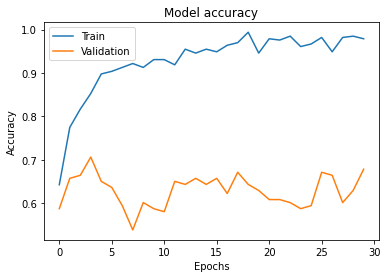

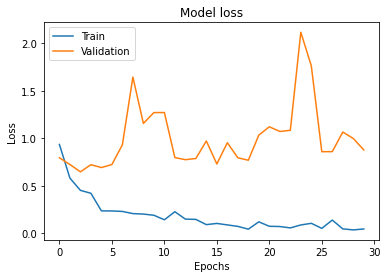

In [287]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

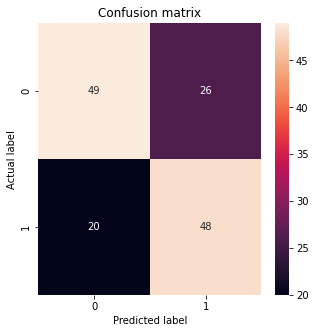

In [288]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [289]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        75
           1       0.65      0.71      0.68        68

    accuracy                           0.68       143
   macro avg       0.68      0.68      0.68       143
weighted avg       0.68      0.68      0.68       143



In [ ]:
# 3-1-3

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.0001(네번째자리)

## 데이터 바로 사용해도 되는지 확인

In [290]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [291]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [292]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [293]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [294]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
6/6 [==============================] - 9s 1s/step - loss: 0.9308 - accuracy: 0.5976 - val_loss: 0.9218 - val_accuracy: 0.5315
Epoch 2/50
6/6 [==============================] - 4s 665ms/step - loss: 0.6006 - accuracy: 0.7538 - val_loss: 0.8762 - val_accuracy: 0.5734
Epoch 3/50
6/6 [==============================] - 4s 647ms/step - loss: 0.3683 - accuracy: 0.8408 - val_loss: 0.8590 - val_accuracy: 0.6364
Epoch 4/50
6/6 [==============================] - 4s 580ms/step - loss: 0.3294 - accuracy: 0.8679 - val_loss: 0.8997 - val_accuracy: 0.6364
Epoch 5/50
6/6 [==============================] - 4s 632ms/step - loss: 0.3316 - accuracy: 0.8859 - val_loss: 1.0716 - val_accuracy: 0.5874
Epoch 6/50
6/6 [==============================] - 4s 724ms/step - loss: 0.3198 - accuracy: 0.8829 - val_loss: 1.2101 - val_accuracy: 0.5734
Epoch 7/50
6/6 [==============================] - 4s 634ms/step - loss: 0.2918 - accuracy: 0.8709 - val_loss: 1.3724 - val_accuracy: 0.5594
Epoch 8/50
6/6 [=======

## (6) 예측하기

In [295]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [296]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0
 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0
 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[1.00829281e-01 8.99170697e-01]
 [9.92097497e-01 7.90246017e-03]
 [3.03358007e-02 9.69664216e-01]
 [9.79878187e-01 2.01217439e-02]
 [8.09923708e-01 1.90076262e-01]
 [9.78114367e-01 2.18856875e-02]
 [4.48366279e-07 9.99999523e-01]
 [9.97774422e-01 2.22552149e-03]
 [6.93630636e-01 3.06369334e-01]
 [9.84672964e-01 1.53270671e-02]
 [2.16584725e-04 9.99783456e-01]
 [6.31597459e-01 3.68402600e-01]
 [6.05908008e-06 9.999

In [297]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.769231


## loss, accuracy 시각화

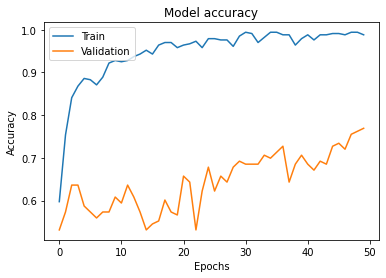

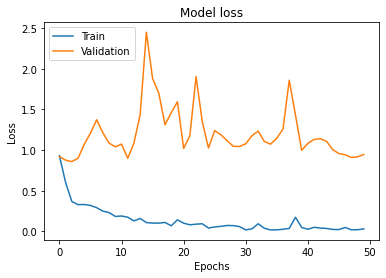

In [298]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

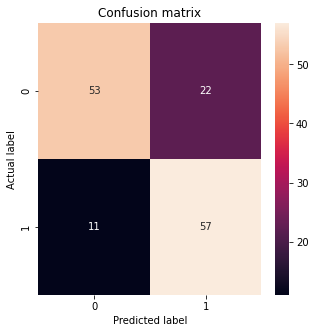

In [299]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [300]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76        75
           1       0.72      0.84      0.78        68

    accuracy                           0.77       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.77      0.77       143



In [ ]:
# 3-2-1

## 정규화, random_state=42, batch_size=64, epochs=10, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [301]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [302]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [303]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [304]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [305]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 9s 830ms/step - loss: 1.0447 - accuracy: 0.5676 - val_loss: 1.5230 - val_accuracy: 0.5175
Epoch 2/10
6/6 [==============================] - 4s 645ms/step - loss: 1.0143 - accuracy: 0.5556 - val_loss: 1.4545 - val_accuracy: 0.5175
Epoch 3/10
6/6 [==============================] - 4s 761ms/step - loss: 0.8377 - accuracy: 0.6456 - val_loss: 1.4387 - val_accuracy: 0.5105
Epoch 4/10
6/6 [==============================] - 4s 648ms/step - loss: 0.7781 - accuracy: 0.6366 - val_loss: 1.4530 - val_accuracy: 0.5175
Epoch 5/10
6/6 [==============================] - 4s 767ms/step - loss: 0.7574 - accuracy: 0.6817 - val_loss: 1.3661 - val_accuracy: 0.5105
Epoch 6/10
6/6 [==============================] - 4s 639ms/step - loss: 0.7054 - accuracy: 0.6937 - val_loss: 1.2829 - val_accuracy: 0.5035
Epoch 7/10
6/6 [==============================] - 4s 584ms/step - loss: 0.6919 - accuracy: 0.6907 - val_loss: 1.2711 - val_accuracy: 0.4965
Epoch 8/10
6/6 [====

## (6) 예측하기

In [306]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [307]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.95912904 0.04087097]
 [0.96939486 0.03060509]
 [0.95537174 0.04462832]
 [0.8019898  0.1980102 ]
 [0.85245377 0.14754626]
 [0.78551817 0.21448183]
 [0.98664564 0.01335437]
 [0.90113527 0.09886467]
 [0.50574285 0.49425718]
 [0.96184343 0.03815652]
 [0.96087503 0.039125  ]
 [0.68972003 0.31027997]
 [0.9677976  0.03220241]
 [0.64715666 0.35284334]
 [0.8496611  0.1503389 ]
 [0.74341035 0.25658965]
 [0.8905702  0.109

In [308]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.510490


## loss, accuracy 시각화

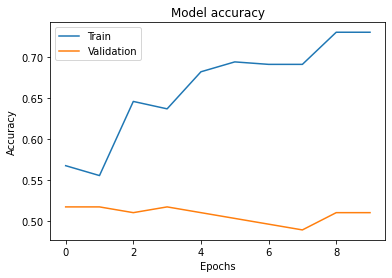

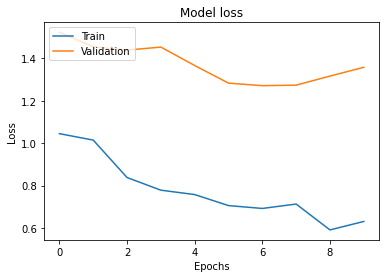

In [309]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

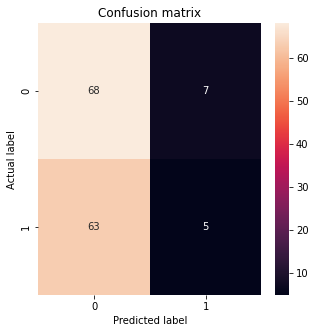

In [310]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [311]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.52      0.91      0.66        75
           1       0.42      0.07      0.12        68

    accuracy                           0.51       143
   macro avg       0.47      0.49      0.39       143
weighted avg       0.47      0.51      0.41       143



In [ ]:
# 3-2-2

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [312]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [313]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [314]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [315]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [316]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
6/6 [==============================] - 9s 789ms/step - loss: 0.9904 - accuracy: 0.5435 - val_loss: 0.8313 - val_accuracy: 0.5594
Epoch 2/30
6/6 [==============================] - 4s 640ms/step - loss: 1.0033 - accuracy: 0.5405 - val_loss: 0.8470 - val_accuracy: 0.5734
Epoch 3/30
6/6 [==============================] - 4s 640ms/step - loss: 0.8036 - accuracy: 0.6246 - val_loss: 0.8162 - val_accuracy: 0.5734
Epoch 4/30
6/6 [==============================] - 4s 612ms/step - loss: 0.7858 - accuracy: 0.6366 - val_loss: 0.7911 - val_accuracy: 0.5664
Epoch 5/30
6/6 [==============================] - 4s 620ms/step - loss: 0.7465 - accuracy: 0.6697 - val_loss: 0.7776 - val_accuracy: 0.5804
Epoch 6/30
6/6 [==============================] - 4s 769ms/step - loss: 0.6896 - accuracy: 0.7237 - val_loss: 0.7705 - val_accuracy: 0.5874
Epoch 7/30
6/6 [==============================] - 4s 629ms/step - loss: 0.7028 - accuracy: 0.7087 - val_loss: 0.7788 - val_accuracy: 0.5874
Epoch 8/30
6/6 [====

## (6) 예측하기

In [317]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [318]:
print(pred_class)
print(y_val)
print(pred)

[1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1
 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0
 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.49926475 0.5007352 ]
 [0.81115544 0.18884459]
 [0.78947407 0.21052596]
 [0.8938963  0.10610372]
 [0.01692956 0.98307043]
 [0.8652273  0.1347727 ]
 [0.42248595 0.57751405]
 [0.95829535 0.04170469]
 [0.61986864 0.3801314 ]
 [0.93805236 0.06194764]
 [0.35755187 0.6424481 ]
 [0.8220159  0.17798409]
 [0.11463657 0.88536346]
 [0.5034715  0.4965285 ]
 [0.99763346 0.00236658]
 [0.49105453 0.50894547]
 [0.696819   0.303

In [319]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.636364


## loss, accuracy 시각화

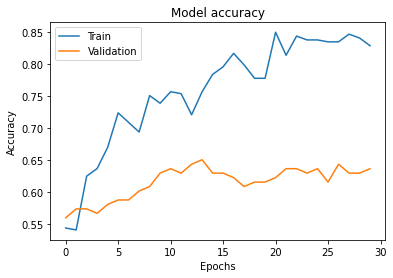

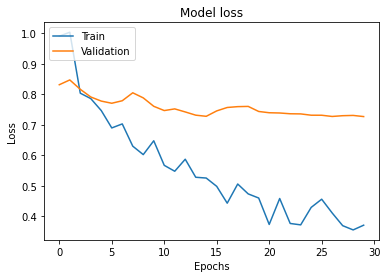

In [320]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

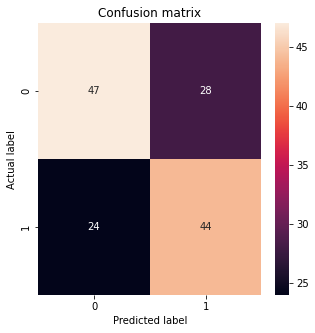

In [321]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [322]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64        75
           1       0.61      0.65      0.63        68

    accuracy                           0.64       143
   macro avg       0.64      0.64      0.64       143
weighted avg       0.64      0.64      0.64       143



In [ ]:
# 3-2-3

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.00001(다섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [323]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [324]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [325]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [326]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [327]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
6/6 [==============================] - 9s 833ms/step - loss: 1.2185 - accuracy: 0.4835 - val_loss: 0.9571 - val_accuracy: 0.4965
Epoch 2/50
6/6 [==============================] - 4s 606ms/step - loss: 1.0409 - accuracy: 0.5195 - val_loss: 0.9002 - val_accuracy: 0.5315
Epoch 3/50
6/6 [==============================] - 4s 653ms/step - loss: 0.7980 - accuracy: 0.6246 - val_loss: 0.9202 - val_accuracy: 0.5245
Epoch 4/50
6/6 [==============================] - 4s 681ms/step - loss: 0.8255 - accuracy: 0.6156 - val_loss: 0.9205 - val_accuracy: 0.5455
Epoch 5/50
6/6 [==============================] - 4s 672ms/step - loss: 0.6499 - accuracy: 0.6817 - val_loss: 0.8691 - val_accuracy: 0.5455
Epoch 6/50
6/6 [==============================] - 4s 618ms/step - loss: 0.6777 - accuracy: 0.6937 - val_loss: 0.8452 - val_accuracy: 0.5455
Epoch 7/50
6/6 [==============================] - 4s 753ms/step - loss: 0.6603 - accuracy: 0.6997 - val_loss: 0.8576 - val_accuracy: 0.5664
Epoch 8/50
6/6 [====

## (6) 예측하기

In [328]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [329]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.5993657  0.4006343 ]
 [0.995434   0.00456599]
 [0.7755584  0.22444157]
 [0.82318    0.17681995]
 [0.39874822 0.6012518 ]
 [0.5064102  0.4935898 ]
 [0.2716393  0.7283607 ]
 [0.2726186  0.72738147]
 [0.790165   0.20983501]
 [0.9540632  0.04593682]
 [0.7413298  0.2586702 ]
 [0.1375818  0.8624182 ]
 [0.07250232 0.9274977 ]
 [0.43607214 0.5639278 ]
 [0.5049466  0.49505338]
 [0.16996673 0.8300333 ]
 [0.05985057 0.940

In [330]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.650350


## loss, accuracy 시각화

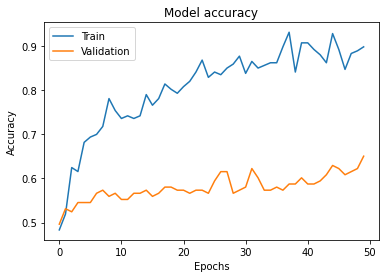

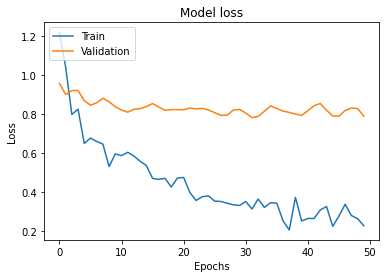

In [331]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

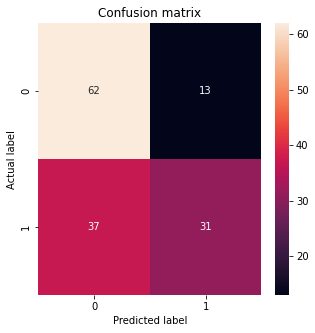

In [332]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [333]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.63      0.83      0.71        75
           1       0.70      0.46      0.55        68

    accuracy                           0.65       143
   macro avg       0.67      0.64      0.63       143
weighted avg       0.66      0.65      0.64       143



In [ ]:
# 3-3-1

## 정규화, random_state=42, batch_size=64, epochs=10, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [334]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [335]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [336]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [337]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [338]:
history = model.fit(augmented_images, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
6/6 [==============================] - 9s 826ms/step - loss: 1.0938 - accuracy: 0.5405 - val_loss: 0.8307 - val_accuracy: 0.5524
Epoch 2/10
6/6 [==============================] - 4s 641ms/step - loss: 1.1007 - accuracy: 0.5075 - val_loss: 0.8298 - val_accuracy: 0.5664
Epoch 3/10
6/6 [==============================] - 4s 766ms/step - loss: 0.9804 - accuracy: 0.5526 - val_loss: 0.8297 - val_accuracy: 0.5594
Epoch 4/10
6/6 [==============================] - 4s 579ms/step - loss: 0.9312 - accuracy: 0.6006 - val_loss: 0.8300 - val_accuracy: 0.5594
Epoch 5/10
6/6 [==============================] - 4s 666ms/step - loss: 1.0529 - accuracy: 0.5706 - val_loss: 0.8325 - val_accuracy: 0.5524
Epoch 6/10
6/6 [==============================] - 4s 629ms/step - loss: 1.0392 - accuracy: 0.5435 - val_loss: 0.8350 - val_accuracy: 0.5524
Epoch 7/10
6/6 [==============================] - 4s 750ms/step - loss: 1.1095 - accuracy: 0.5405 - val_loss: 0.8379 - val_accuracy: 0.5524
Epoch 8/10
6/6 [====

## (6) 예측하기

In [339]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [340]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1
 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.658968   0.34103206]
 [0.9314178  0.06858213]
 [0.92544466 0.07455532]
 [0.19817282 0.8018272 ]
 [0.63897616 0.36102384]
 [0.9845637  0.01543622]
 [0.9741732  0.02582678]
 [0.8425473  0.15745275]
 [0.16185637 0.8381437 ]
 [0.08710032 0.91289973]
 [0.16416058 0.8358394 ]
 [0.41469288 0.5853071 ]
 [0.9606514  0.03934856]
 [0.20894621 0.7910538 ]
 [0.71727186 0.2827281 ]
 [0.8309105  0.1690895 ]
 [0.96586555 0.034

In [341]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.552448


## loss, accuracy 시각화

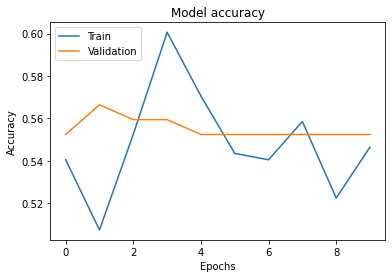

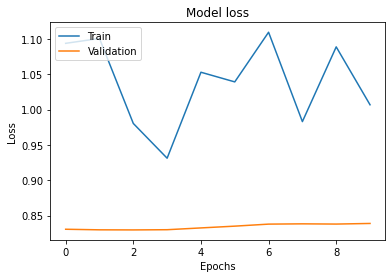

In [342]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

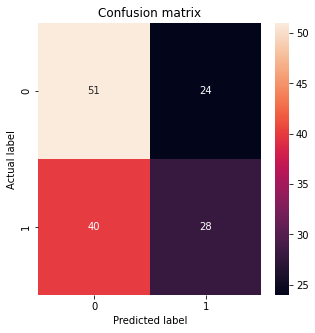

In [343]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [344]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.56      0.68      0.61        75
           1       0.54      0.41      0.47        68

    accuracy                           0.55       143
   macro avg       0.55      0.55      0.54       143
weighted avg       0.55      0.55      0.54       143



In [ ]:
# 3-3-2

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [345]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [346]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [347]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [348]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [349]:
history = model.fit(augmented_images, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
6/6 [==============================] - 10s 854ms/step - loss: 1.2866 - accuracy: 0.5225 - val_loss: 0.9359 - val_accuracy: 0.6014
Epoch 2/30
6/6 [==============================] - 4s 664ms/step - loss: 1.2674 - accuracy: 0.5375 - val_loss: 0.9301 - val_accuracy: 0.6014
Epoch 3/30
6/6 [==============================] - 4s 641ms/step - loss: 1.2405 - accuracy: 0.4925 - val_loss: 0.9301 - val_accuracy: 0.5664
Epoch 4/30
6/6 [==============================] - 4s 645ms/step - loss: 1.1527 - accuracy: 0.5345 - val_loss: 0.9337 - val_accuracy: 0.5594
Epoch 5/30
6/6 [==============================] - 4s 634ms/step - loss: 1.0912 - accuracy: 0.5375 - val_loss: 0.9395 - val_accuracy: 0.5245
Epoch 6/30
6/6 [==============================] - 4s 647ms/step - loss: 1.0783 - accuracy: 0.5255 - val_loss: 0.9473 - val_accuracy: 0.5245
Epoch 7/30
6/6 [==============================] - 4s 646ms/step - loss: 1.2048 - accuracy: 0.4775 - val_loss: 0.9562 - val_accuracy: 0.5315
Epoch 8/30
6/6 [===

## (6) 예측하기

In [350]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [351]:
print(pred_class)
print(y_val)
print(pred)

[1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1
 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1
 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0
 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.38123482 0.6187652 ]
 [0.9107705  0.08922955]
 [0.46212408 0.5378759 ]
 [0.461427   0.538573  ]
 [0.38329872 0.61670125]
 [0.16187373 0.83812624]
 [0.14926358 0.8507364 ]
 [0.5860399  0.41396013]
 [0.63612485 0.3638751 ]
 [0.9362436  0.06375635]
 [0.2749356  0.7250644 ]
 [0.41800046 0.5819995 ]
 [0.41787487 0.5821251 ]
 [0.17889106 0.82110894]
 [0.09539735 0.9046026 ]
 [0.38918018 0.6108198 ]
 [0.06958707 0.930

In [352]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.552448


## loss, accuracy 시각화

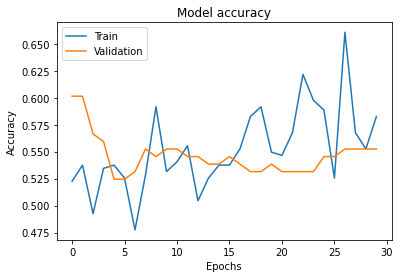

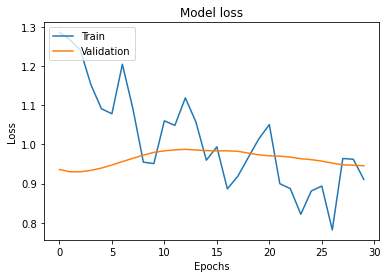

In [353]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

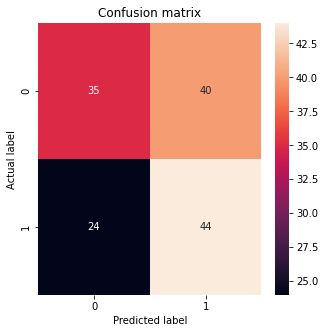

In [354]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [355]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.59      0.47      0.52        75
           1       0.52      0.65      0.58        68

    accuracy                           0.55       143
   macro avg       0.56      0.56      0.55       143
weighted avg       0.56      0.55      0.55       143



In [ ]:
# 3-3-3

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.000001(여섯번째자리)

## 데이터 바로 사용해도 되는지 확인

In [356]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## 데이터 증강

In [357]:
# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(x_train, y_train, batch_size=64)

## (4) 모델 정의 및 컴파일
## MobileNetV2 모델 쌓기

In [358]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [359]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [360]:
history = model.fit(augmented_images, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
6/6 [==============================] - 9s 862ms/step - loss: 0.9676 - accuracy: 0.5556 - val_loss: 1.1244 - val_accuracy: 0.4755
Epoch 2/50
6/6 [==============================] - 4s 637ms/step - loss: 1.0403 - accuracy: 0.5315 - val_loss: 1.1298 - val_accuracy: 0.4755
Epoch 3/50
6/6 [==============================] - 4s 585ms/step - loss: 1.1250 - accuracy: 0.5135 - val_loss: 1.1313 - val_accuracy: 0.4755
Epoch 4/50
6/6 [==============================] - 4s 640ms/step - loss: 1.0157 - accuracy: 0.5285 - val_loss: 1.1337 - val_accuracy: 0.4755
Epoch 5/50
6/6 [==============================] - 4s 602ms/step - loss: 0.9626 - accuracy: 0.5616 - val_loss: 1.1381 - val_accuracy: 0.4755
Epoch 6/50
6/6 [==============================] - 4s 580ms/step - loss: 1.0406 - accuracy: 0.4955 - val_loss: 1.1449 - val_accuracy: 0.4825
Epoch 7/50
6/6 [==============================] - 4s 636ms/step - loss: 0.8933 - accuracy: 0.5586 - val_loss: 1.1551 - val_accuracy: 0.4895
Epoch 8/50
6/6 [====

## (6) 예측하기

In [361]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1) -> 이 친구를 안 하는 이유는 원핫인코딩을 하지 않았기 때문에? 안해도 된다?

In [362]:
print(pred_class)
print(y_val)
print(pred)

[1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.0954704  0.90452963]
 [0.62616026 0.37383974]
 [0.9249372  0.0750628 ]
 [0.18325809 0.8167419 ]
 [0.1570678  0.84293216]
 [0.21727036 0.7827296 ]
 [0.5999496  0.4000504 ]
 [0.06412394 0.9358761 ]
 [0.7295854  0.2704146 ]
 [0.32849145 0.67150855]
 [0.3068517  0.69314826]
 [0.31212866 0.6878714 ]
 [0.04000822 0.9599918 ]
 [0.18639423 0.81360584]
 [0.40716597 0.592834  ]
 [0.00724206 0.9927579 ]
 [0.00808753 0.991

In [363]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.426573


## loss, accuracy 시각화

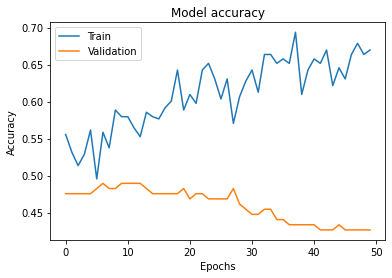

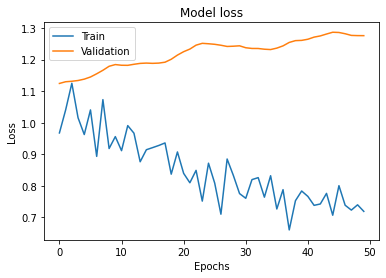

In [364]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

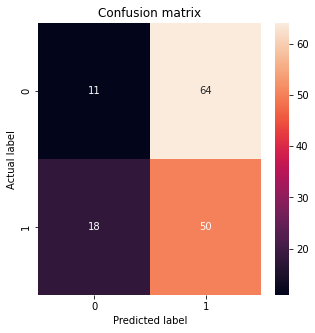

In [365]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [366]:
print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.38      0.15      0.21        75
           1       0.44      0.74      0.55        68

    accuracy                           0.43       143
   macro avg       0.41      0.44      0.38       143
weighted avg       0.41      0.43      0.37       143



In [18]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # EarlyStopping과 ModelCheckpoint 객체를 생성합니다.
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# # fit 함수를 호출할 때 callbacks 매개변수에 early_stopping과 model_checkpoint를 전달합니다.
# hist = model.fit(train_generator, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
13/13 [==============================] - 5s 366ms/step - loss: 1.5118 - accuracy: 0.6963 - val_loss: 36.2442 - val_accuracy: 0.7491


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
13/13 [==============================] - 5s 338ms/step - loss: 1.4348 - accuracy: 0.7062 - val_loss: 40.8004 - val_accuracy: 0.2509
Epoch 3/30
13/13 [==============================] - 5s 344ms/step - loss: 2.3824 - accuracy: 0.6889 - val_loss: 69.5486 - val_accuracy: 0.7491
Epoch 4/30
13/13 [==============================] - 5s 348ms/step - loss: 1.3403 - accuracy: 0.6963 - val_loss: 0.5931 - val_accuracy: 0.7565
Epoch 5/30
13/13 [==============================] - 5s 348ms/step - loss: 1.6925 - accuracy: 0.6864 - val_loss: 69.8222 - val_accuracy: 0.2546
Epoch 6/30
13/13 [==============================] - 5s 338ms/step - loss: 1.2034 - accuracy: 0.7210 - val_loss: 47.7352 - val_accuracy: 0.6679
Epoch 7/30
13/13 [==============================] - 5s 353ms/step - loss: 1.9310 - accuracy: 0.6963 - val_loss: 61.8602 - val_accuracy: 0.7491
